# Notebook: Metaphor Analysis

This notebook is meant to analyse the metaphors detected by the REGEX and POS approaches.

The analysis will focus on:
- frequency of the word "inflation" related to the inflation rate
- Sentiment analysis of the metaphors flagged
- Poisson regression, with the metaphors sentiment score 

In [2]:
import re
import ast
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from ecbdata import ecbdata
from itertools import product
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from scikeras.wrappers import KerasClassifier
from transformers import AutoTokenizer, TFAutoModel, pipeline

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Embedding, GlobalAveragePooling1D

tqdm.pandas()

#ECB Color
color = (17/255, 49/255, 147/255)

# TODO: Pie Chart of the Categories
# TODO: Compare "list_regex" and "list_regex_reduced" with GPT - Metrics !
# TODO: WordCloud Categories (Other vs Orientation vs ALL)
# TODO: Pie chart for the categories: Man vs Female, When Inflation is in bull market vs bear market

C:\Users\School\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Target words:
words_to_match = ["inflation","deflation","inflationary","desinflationary","hyperinflation","disinflation"]

In [4]:
# Functions

# Function to count the frequency of words from the list in a sentence
def count_frequency(answer, words_to_match):
    if pd.isna(answer):
        return 0
    sentence_lower = answer.lower()
    return sum(sentence_lower.count(word) for word in words_to_match)

# Function to remove stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stop)])
    return text

In [5]:
# Import dataset containing the interveiw data
df = pd.read_csv('Data/Final_Data.csv')

# Convert 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# For computation speed, limit the data to the last 50 rows:
#df = df.tail(50)

start = df["Date"].min()
start = start.strftime('%Y-%m')
df2 = ecbdata.get_series('ICP.M.U2.N.000000.4.ANR', 
                        start=start)
df2["TIME_PERIOD"] = pd.to_datetime(df2["TIME_PERIOD"])
print("Start date is: ",start)

df.head()

Start date is:  2005-01


Unnamed: 0       Date                                              Media  \
0           0 2005-12-23                         Interview with Der Spiegel   
1           1 2005-12-19                  Interview with Hospodářské Noviny   
2           2 2005-12-19  Interview with Financial Times and Financial T...   
3           3 2005-12-15                         Interview with Paris Match   
4           4 2005-12-09                           Interview in Il Giornale   

                Member                                               Link  \
0  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/200...   
1         Otmar Issing  https://www.ecb.europa.eu/press/inter/date/200...   
2      Lucas Papademos  https://www.ecb.europa.eu/press/inter/date/200...   
3  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/200...   
4  Lorenzo Bini Smaghi  https://www.ecb.europa.eu/press/inter/date/200...   

             Information                                          Questions  \
0  Information not found  SPIEGEL: Monsieur Trichet, any concrete uttera...   
1  Information not found  The new EU member states want to adopt the eur...   
2  Information not found  Mr Papademos, you have responsibility as ECB V...   
3  Information not found  Paris Match. After two uneventful years at the...   
4  Information not found  However, Europe’s politicians, with few except...   

                                             Answers Metaphors  \
0  The publication of the translation was authori...       NaN   
1  These questions are all closely related to eac...       NaN   
2  A comparison of the risks involved when short-...       NaN   
3  The publication of the translation was authori...       NaN   
4  By Angelo Allegri, our correspondent in Frankf...       NaN   

  Metaphors Sentence  ...                                          Sentences  \
0                NaN  ...  ['We will in the future take the decisions tha...   
1                NaN  ...  ['We are not confronted with deflation but wit...   
2                NaN  ...  ['If longterm interest rates remain at a low l...   
3                NaN  ...  ['You are exaggerating the increase in the cos...   
4                NaN  ...  ['The rise has helped to keep inflation expect...   

  Frequency Sentences_len                              Sentence_GPT_Majority  \
0         5             3  ['we will in the future take the decisions tha...   
1         1             1  ['we are not confronted with deflation but wit...   
2        18            11  ['in the us the policy stance changed and the ...   
3         7             5  ['furthermore we must not wait until inflation...   
4         7             7  ['the rise has helped to keep inflation expect...   

                               GPT_Majority_Category  \
0                    ['machine', 'disease', 'plant']   
1                                        ['warfare']   
2                   ['fire', 'fire', 'fire', 'fire']   
3  ['warfare', 'disease', 'disease', 'machine', '...   
4  ['orientation', 'orientation', 'orientation', ...   

                            Matched_Metaphors  \
0                          [True, True, True]   
1                                      [True]   
2                    [True, True, True, True]   
3              [True, True, True, True, True]   
4  [True, True, True, True, True, True, True]   

                                   pos_relationships  \
0  [('inflationary', 'expectation'), ('inflation'...   
1                                                 []   
2  [('future', 'inflation'), ('low', 'inflation')...   
3  [('inflationary', 'remain'), ('inflationary', ...   
4                          [('inflation', 'regard')]   

                                       pos_sentences  pos_relationships_len  \
0                                                 []                      3   
1                                                 []                      0   
2  ['it a higher level of

In [6]:
print("Shape of the dataset before dropping missing values: ", df.shape)
df.isna().sum()

Shape of the dataset before dropping missing values:  (519, 31)


Unnamed: 0                  0
Date                        0
Media                       0
Member                      0
Link                        0
Information                 0
Questions                  51
Answers                    10
Metaphors                 451
Metaphors Sentence        451
YoB                         0
Gender                      0
Country                     0
Period on the Board         0
list_regex                  0
list_regex_reduced          0
list_regex_len              0
list_regex_reduced_len      0
text_length                 0
pos_metaphors               0
pos_metaphors_len           0
Sentences                   0
Frequency                   0
Sentences_len               0
Sentence_GPT_Majority       0
GPT_Majority_Category       0
Matched_Metaphors           0
pos_relationships           0
pos_sentences               0
pos_relationships_len       0
Category_GPT_Majority       0
dtype: int64

In [7]:
print("Shape of the dataset after dropping missing values: ", df.shape)
df.nunique()

Shape of the dataset after dropping missing values:  (519, 31)


Unnamed: 0                519
Date                      489
Media                     259
Member                     19
Link                      519
Information               361
Questions                 465
Answers                   509
Metaphors                  59
Metaphors Sentence         59
YoB                        15
Gender                      2
Country                    10
Period on the Board        14
list_regex                407
list_regex_reduced        407
list_regex_len             38
list_regex_reduced_len     38
text_length               504
pos_metaphors             177
pos_metaphors_len          15
Sentences                 406
Frequency                  43
Sentences_len              35
Sentence_GPT_Majority     406
GPT_Majority_Category     308
Matched_Metaphors          60
pos_relationships         307
pos_sentences             242
pos_relationships_len      28
Category_GPT_Majority     307
dtype: int64

In [8]:
#types of data
df.dtypes

Unnamed: 0                         int64
Date                      datetime64[ns]
Media                             object
Member                            object
Link                              object
Information                       object
Questions                         object
Answers                           object
Metaphors                         object
Metaphors Sentence                object
YoB                                int64
Gender                            object
Country                           object
Period on the Board               object
list_regex                        object
list_regex_reduced                object
list_regex_len                     int64
list_regex_reduced_len             int64
text_length                        int64
pos_metaphors                     object
pos_metaphors_len                  int64
Sentences                         object
Frequency                          int64
Sentences_len                      int64
Sentence_GPT_Maj

In [9]:
"""
# Run only once: The data will be saved in the right format afterwards.

# lambda function to convert string representations of lists into actual lists
parse_list = lambda x: ast.literal_eval(x) if isinstance(x, str) and x != '[\'None\']' else []
df.loc[:, 'Metaphors'] = df['Metaphors'].apply(parse_list)

# lambda function to count the elements in each list
df.loc[:, 'Metaphors_len'] = df['Metaphors'].apply(len)"""

"\n# Run only once: The data will be saved in the right format afterwards.\n\n# lambda function to convert string representations of lists into actual lists\nparse_list = lambda x: ast.literal_eval(x) if isinstance(x, str) and x != '['None']' else []\ndf.loc[:, 'Metaphors'] = df['Metaphors'].apply(parse_list)\n\n# lambda function to count the elements in each list\ndf.loc[:, 'Metaphors_len'] = df['Metaphors'].apply(len)"

In [10]:
# function to convert string representations of lists into actual lists
parse_list = lambda x: ast.literal_eval(x) if x != '[]' else []
df.loc[:, 'Sentence_GPT_Majority'] = df['Sentence_GPT_Majority'].apply(parse_list)

df['GPT_Length'] = df['Sentence_GPT_Majority'].apply(len)

# EDA on the (human) labeled data

In [11]:
# Dataframe with the labeled Metaphors
df_labels = df[df['Metaphors'].notnull()].copy()
print("Shape of the dataset with labeled Metaphors: ", df_labels.shape)

Shape of the dataset with labeled Metaphors:  (68, 32)


In [12]:
df_labels.isna().sum()

Unnamed: 0                0
Date                      0
Media                     0
Member                    0
Link                      0
Information               0
Questions                 6
Answers                   0
Metaphors                 0
Metaphors Sentence        0
YoB                       0
Gender                    0
Country                   0
Period on the Board       0
list_regex                0
list_regex_reduced        0
list_regex_len            0
list_regex_reduced_len    0
text_length               0
pos_metaphors             0
pos_metaphors_len         0
Sentences                 0
Frequency                 0
Sentences_len             0
Sentence_GPT_Majority     0
GPT_Majority_Category     0
Matched_Metaphors         0
pos_relationships         0
pos_sentences             0
pos_relationships_len     0
Category_GPT_Majority     0
GPT_Length                0
dtype: int64

In [13]:
# lambda function to convert string representations of lists into actual lists
parse_list = lambda x: ast.literal_eval(x) if x != '[\'None\']' else []
df_labels.loc[:, 'Metaphors'] = df_labels['Metaphors'].apply(parse_list)

# lambda function to count the elements in each list
df_labels.loc[:, 'Metaphors_len'] = df_labels['Metaphors'].apply(len)

In [14]:
# Count the frequency of words from the list words_to_match
df_labels["Frequency"] = df_labels["Answers"].apply(count_frequency, words_to_match=words_to_match)

In [15]:
df_labels.head()

Unnamed: 0       Date                                              Media  \
47          47 2009-09-12  Interview with the "Junge Zeitung“ of the Fran...   
65          65 2010-04-24                            Interview with Expresso   
73          73 2011-10-18      Interview with Frankfurter Allgemeine Zeitung   
79          79 2011-09-20                           Interview with Expansión   
85          85 2011-06-16                           Interview with The Times   

                 Member                                               Link  \
47  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/200...   
65  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/201...   
73  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/201...   
79  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/201...   
85  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/201...   

              Information                                          Questions  \
47  Information not found                                                NaN   
65  Information not found  Are we really leaving the crisis behind or are...   
73  Information not found  Mr Trichet, do you believe in destiny?[end_que...   
79  Information not found  1. At the last meeting you said that the risks...   
85  Information not found  The Times: There are two camps: one that empha...   

                                              Answers  \
47  Mr. President, as „Mr. Euro“: How many Euros d...   
65  As regards the conjuncture in the real economy...   
73  I have used that term on a few occasions – inc...   
79  At the last meeting of the Governing Council w...   
85  Jean-Claude Trichet: All advanced economies ar...   

                                            Metaphors  \
47  [fear deflation, inflation below, preserved th...   
65                                                 []   
73  [experience of hyperinflationr, experienced hy...   
79  [upside risks to inflation, materialisation of...   
85  [anchor very solidly inflation, materialisatio...   

                                   Metaphors Sentence  ...  Sentences_len  \
47  ['Or does the ECB fear deflation', 'Our defini...  ...              5   
65                                           ['None']  ...              0   
73  ['As regards inflation, I understand the deep-...  ...              6   
79  ['On the other hand, in July there were upside...  ...              2   
85  ['What I would say is that in our case it is v...  ...              6   

                                Sentence_GPT_Majority  \
47  [can you say that you accomplished your missio...   
65                                                 []   
73  [as regards inflation i understand the deepsea...   
79  [on the other hand in july there were upside r...   
85  [we consider that such anchoring has been a ve...   

                                GPT_Majority_Category  \
47                   ['warfare', 'warfare', 'sports']   
65                                                 []   
73                         ['disease', 'orientation']   
79                         ['orientation', 'warfare']   
85  ['orientation', 'sports', 'sports', 'orientati...   

           Matched_Metaphors  \
47       [False, True, True]   
65                        []   
73              [True, True]   
79              [True, True]   
85  [True, True, True, True]   

                                    pos_relationships  \
47    [('deflation', 'fear'), ('clear', 'inflation')]   
65                                                 []   
73  [('average', 'inflation'), ('annual', 'inflati...   
79                                                 []   
85  [('annual', 'inflation'), ('average', 'inflati...   

                                        pos_sentences  pos_relationships_len  \
47                                                 []                      2   
65                                        

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

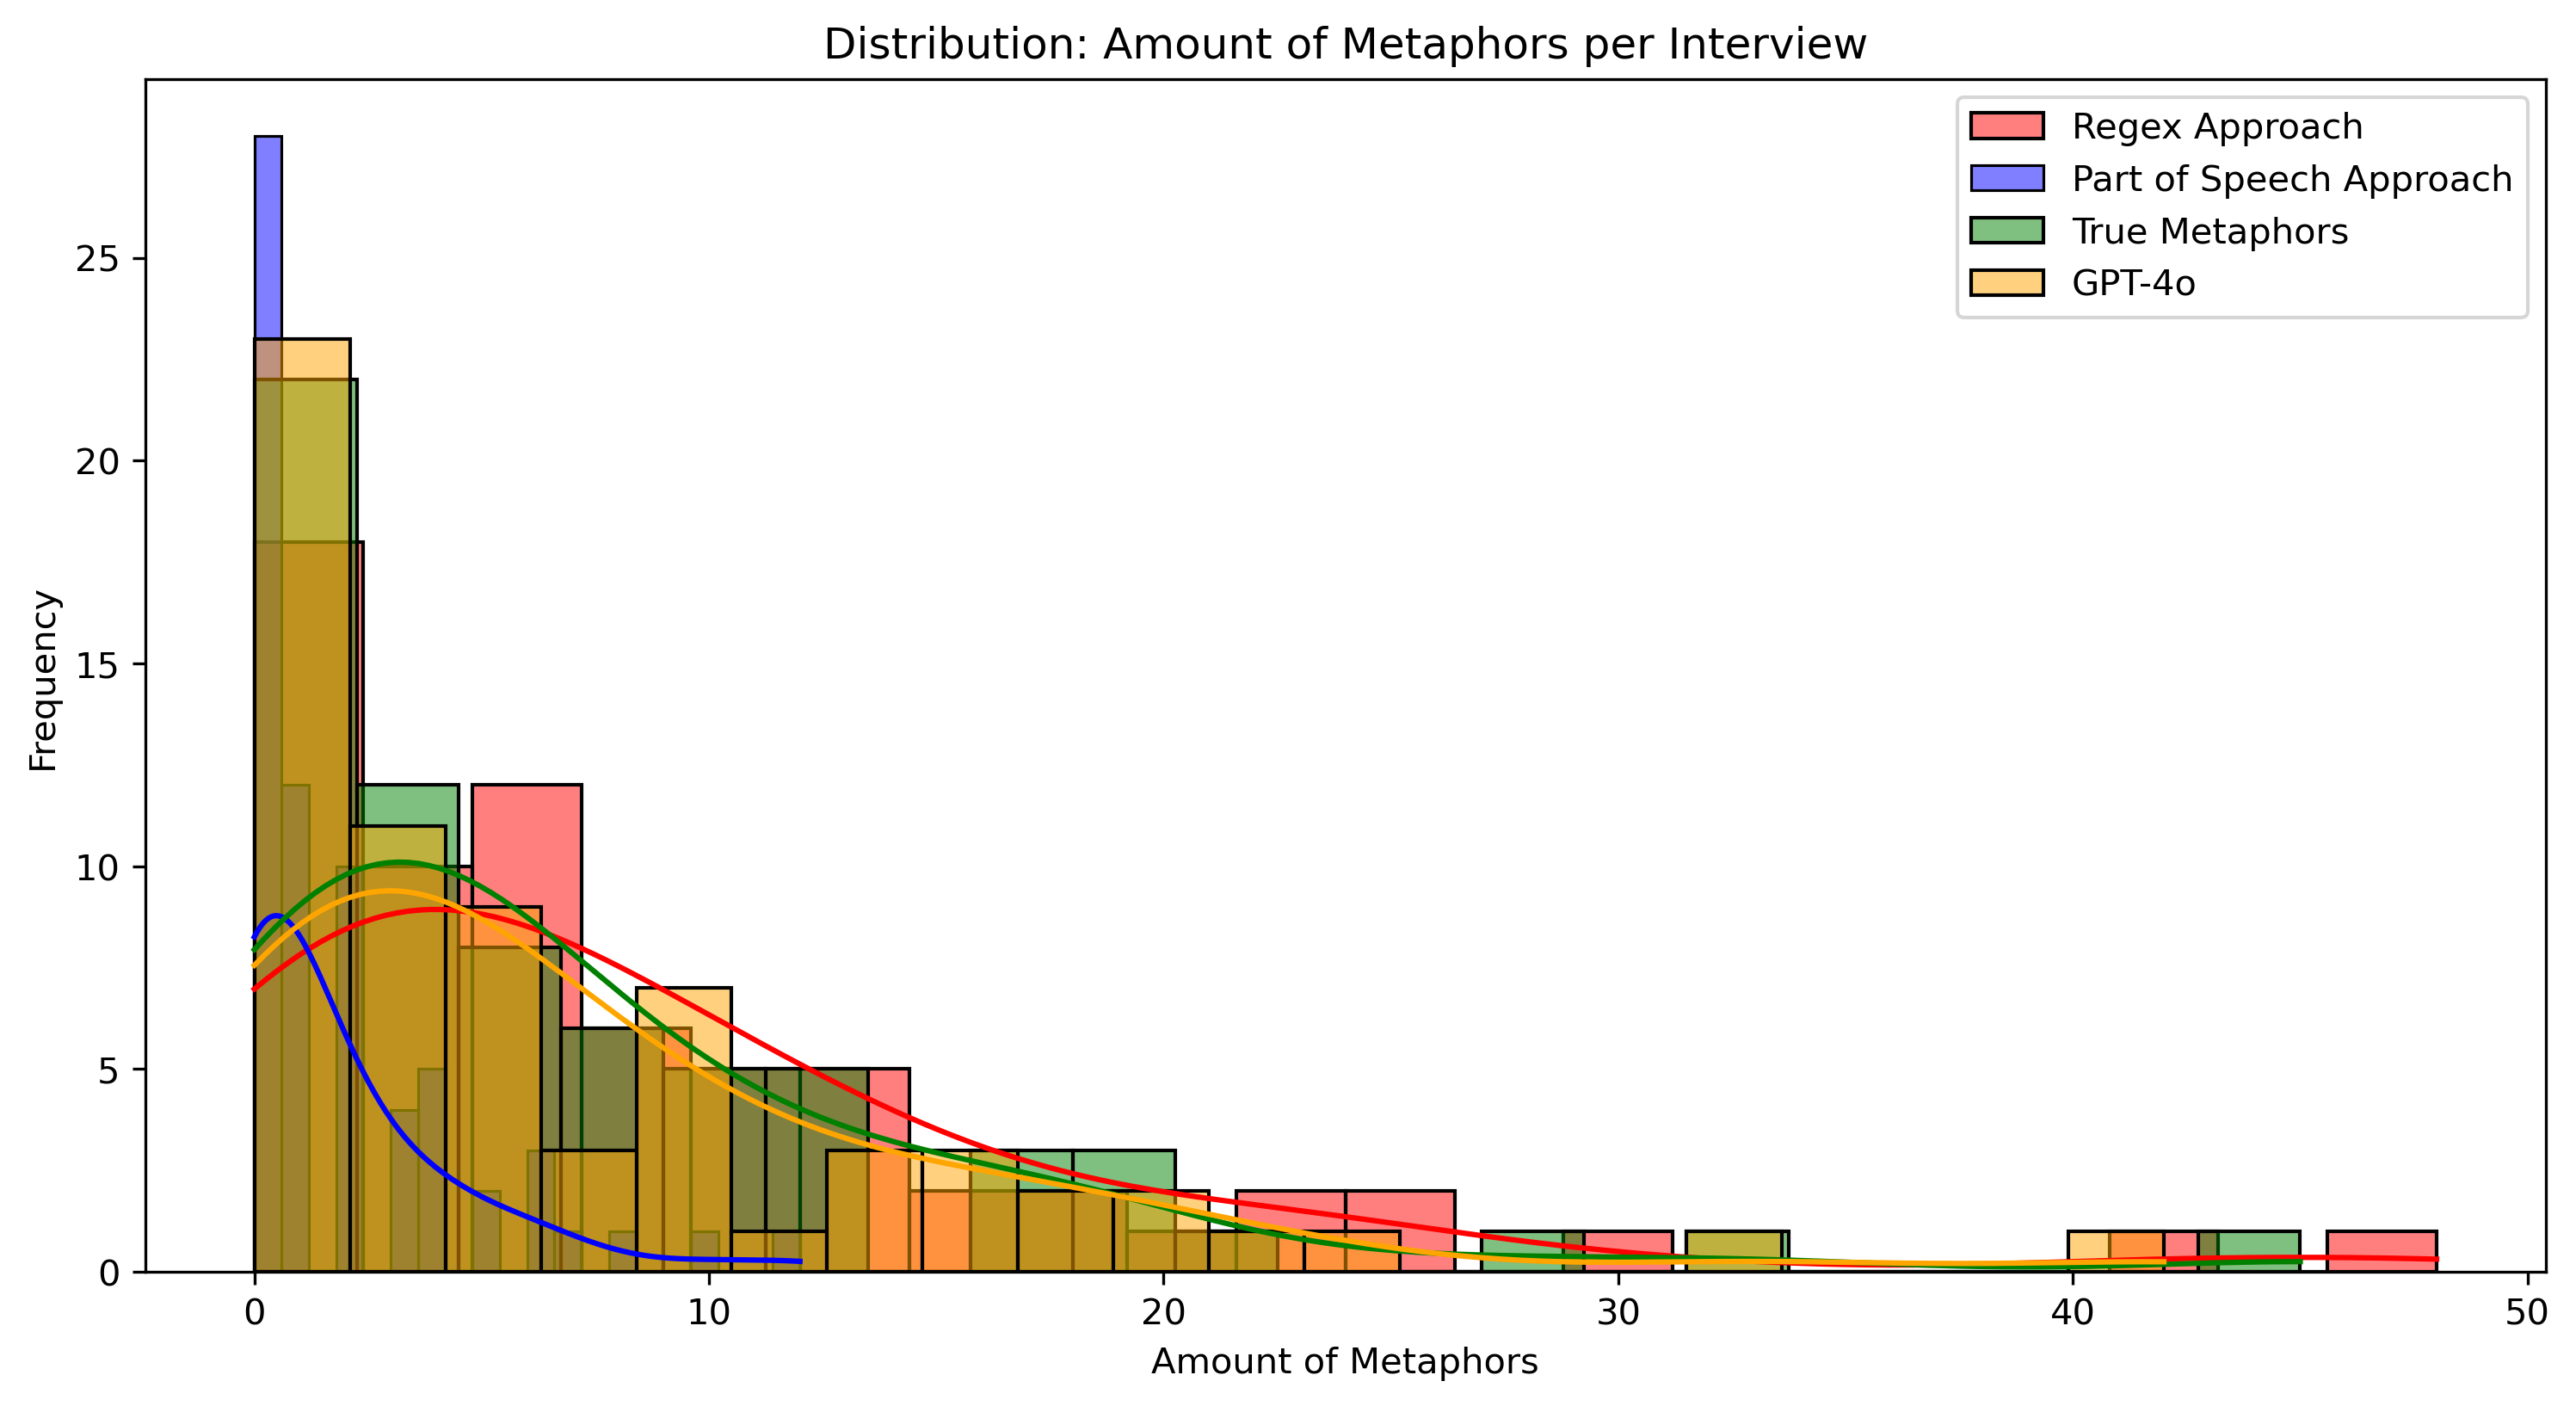

In [16]:
plt.figure(figsize=(12, 6),dpi=300)
sns.histplot(data=df_labels, x='list_regex_reduced_len', bins=20, kde=True, color='red', label='Regex Approach')
sns.histplot(data=df_labels, x='pos_metaphors_len', bins=20, kde=True, color='blue', label='Part of Speech Approach')
sns.histplot(data=df_labels, x='Metaphors_len', bins=20, kde=True, color='green', label='True Metaphors')
sns.histplot(data=df_labels, x='GPT_Length', bins=20, kde=True, color='orange', label='GPT-4o')
plt.title('Distribution: Amount of Metaphors per Interview')
plt.xlabel('Amount of Metaphors')
plt.ylabel('Frequency')
plt.legend()
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

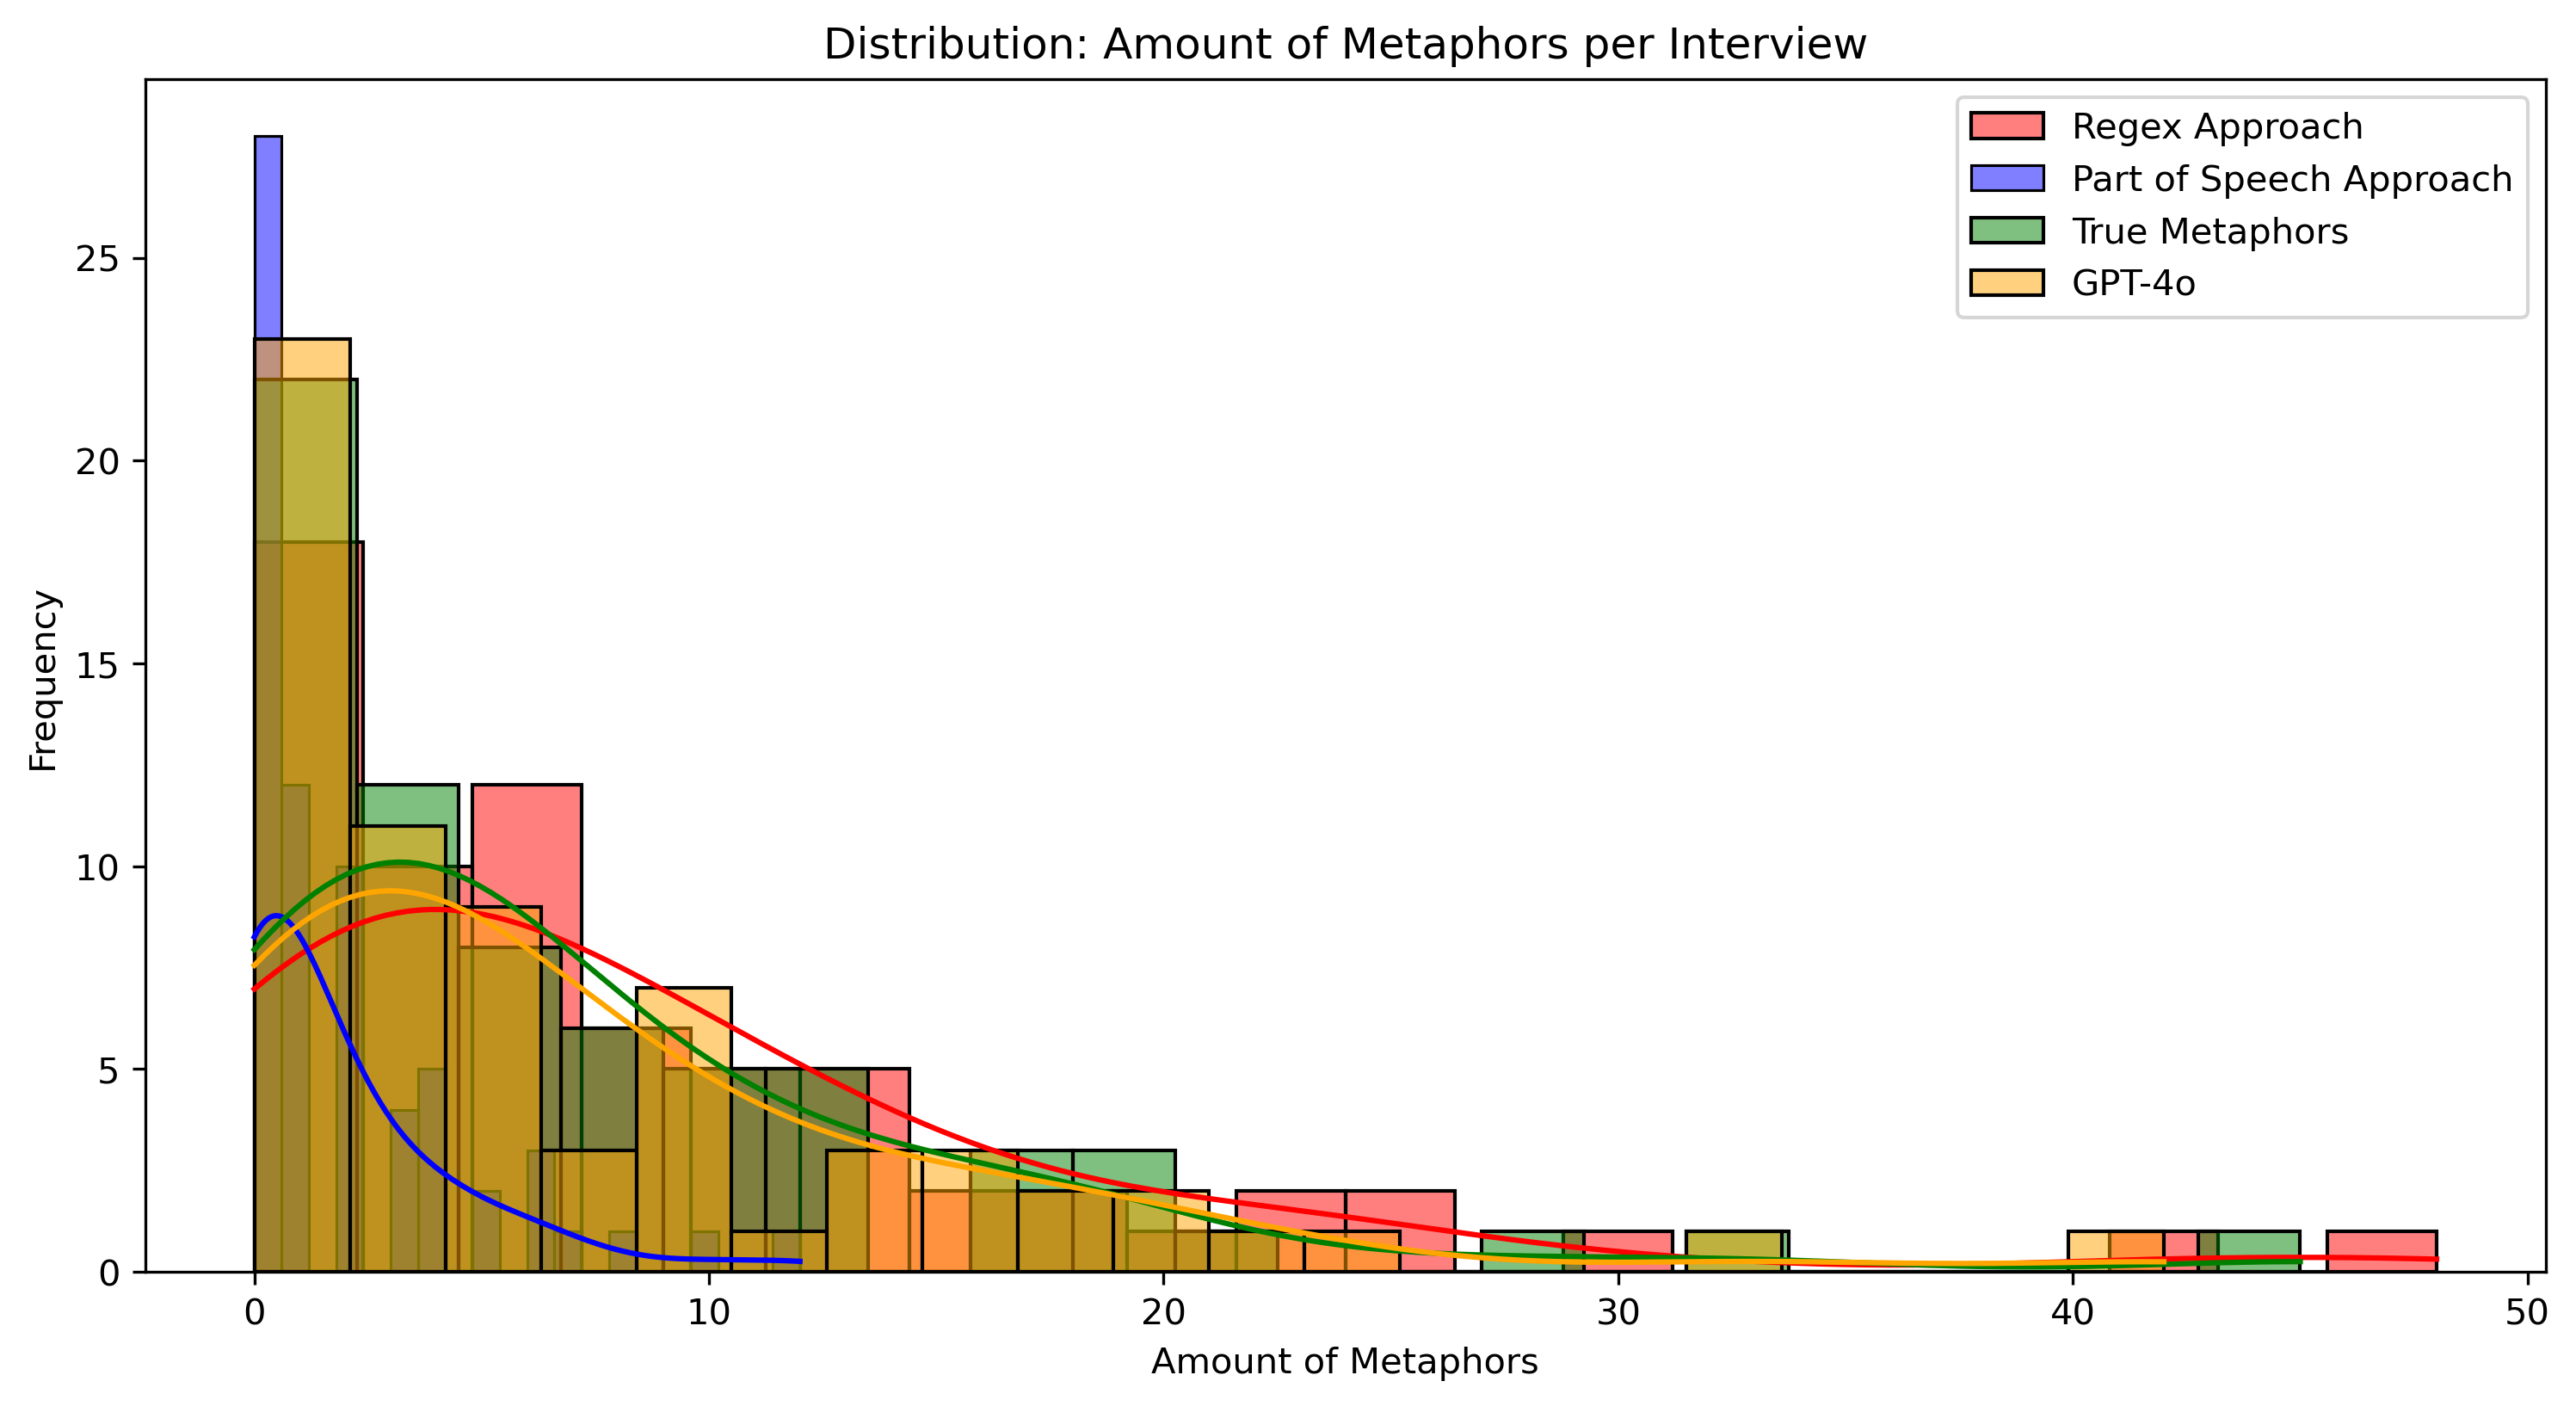

In [17]:
plt.figure(figsize=(12, 6),dpi=300)
sns.histplot(data=df_labels, x='list_regex_reduced_len', bins=20, kde=True, color='red', label='Regex Approach')
sns.histplot(data=df_labels, x='pos_metaphors_len', bins=20, kde=True, color='blue', label='Part of Speech Approach')
sns.histplot(data=df_labels, x='Metaphors_len', bins=20, kde=True, color='green', label='True Metaphors')
sns.histplot(data=df_labels, x='GPT_Length', bins=20, kde=True, color='orange', label='GPT-4o')
plt.title('Distribution: Amount of Metaphors per Interview')
plt.xlabel('Amount of Metaphors')
plt.ylabel('Frequency')
plt.legend()
plt.show()

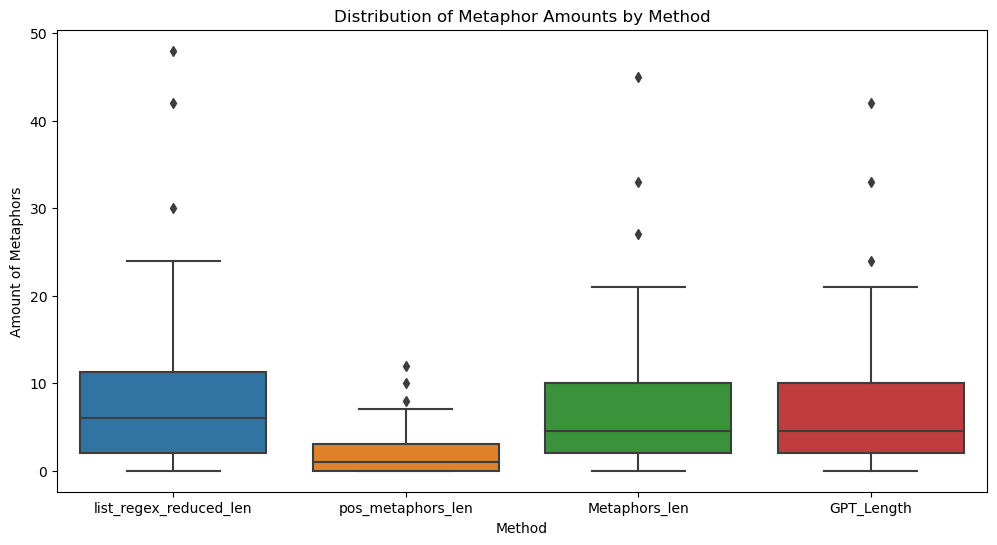

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_labels[['list_regex_reduced_len', 'pos_metaphors_len', 'Metaphors_len', 'GPT_Length']])
plt.title('Distribution of Metaphor Amounts by Method')
plt.xlabel('Method')
plt.ylabel('Amount of Metaphors')
plt.show()

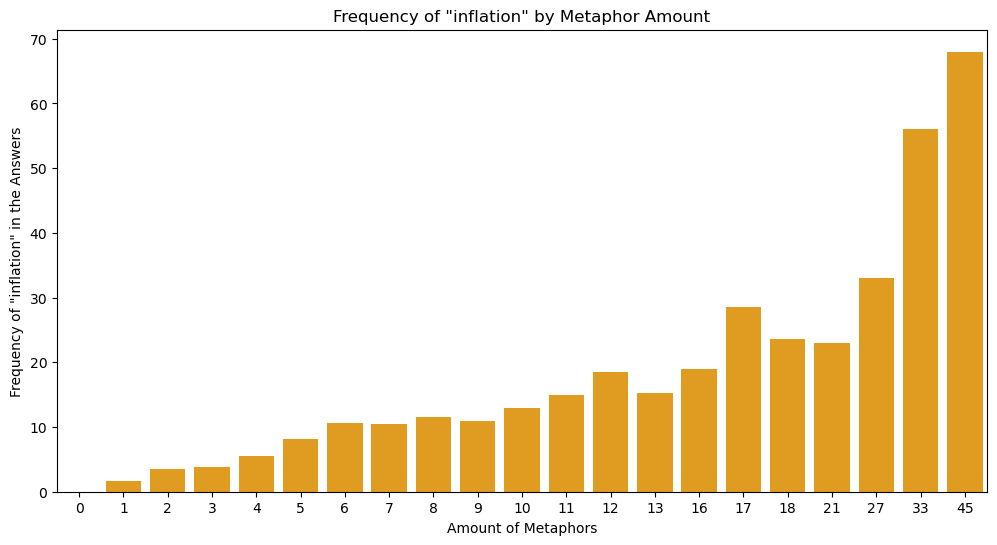

In [19]:
avg_freq_by_length = df_labels.groupby('Metaphors_len')['Frequency'].mean()
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_freq_by_length.index, y=avg_freq_by_length.values, color='orange')
plt.title('Frequency of "inflation" by Metaphor Amount')
plt.xlabel('Amount of Metaphors')
plt.ylabel('Frequency of "inflation" in the Answers')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


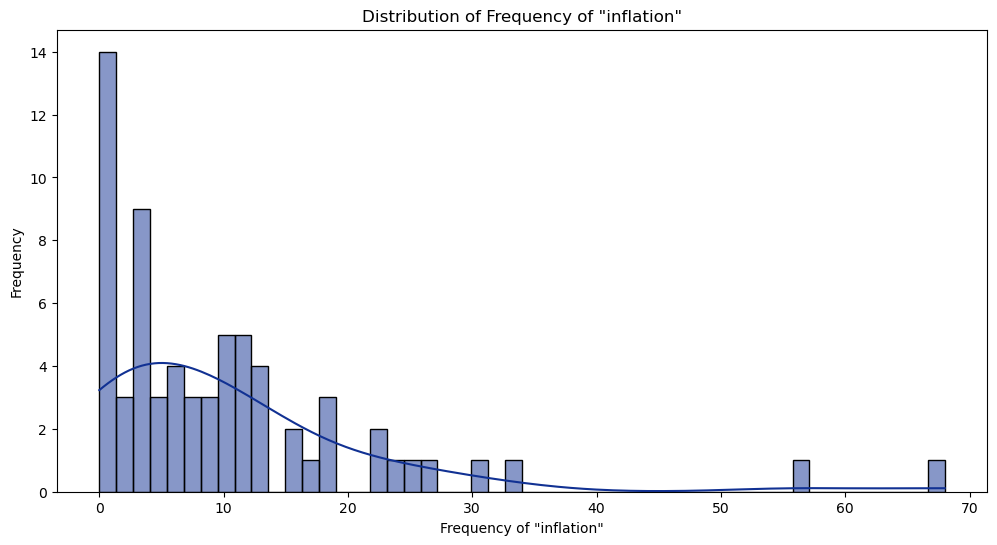

In [20]:
# Plot the Frequency 
plt.figure(figsize=(12, 6))
sns.histplot(data=df_labels, x='Frequency', bins=50, kde=True, color=color)
plt.title('Distribution of Frequency of "inflation"')
plt.xlabel('Frequency of "inflation"')
plt.ylabel('Frequency')
plt.show()

# EDA on the GPT data:

In [21]:
# Add Ratio of Metaphors to the dataframe, Frequency / text length
df['Ratio'] = df['Frequency'] / df['text_length']

In [22]:
"""# Chart of the Metaphors Categories
plt.figure(figsize=(12, 6))
sns.countplot(x='Category_GPT_Majority', data=df, color=color)
plt.title("Metaphors Categories")
plt.show()"""

'# Chart of the Metaphors Categories\nplt.figure(figsize=(12, 6))\nsns.countplot(x=\'Category_GPT_Majority\', data=df, color=color)\nplt.title("Metaphors Categories")\nplt.show()'

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


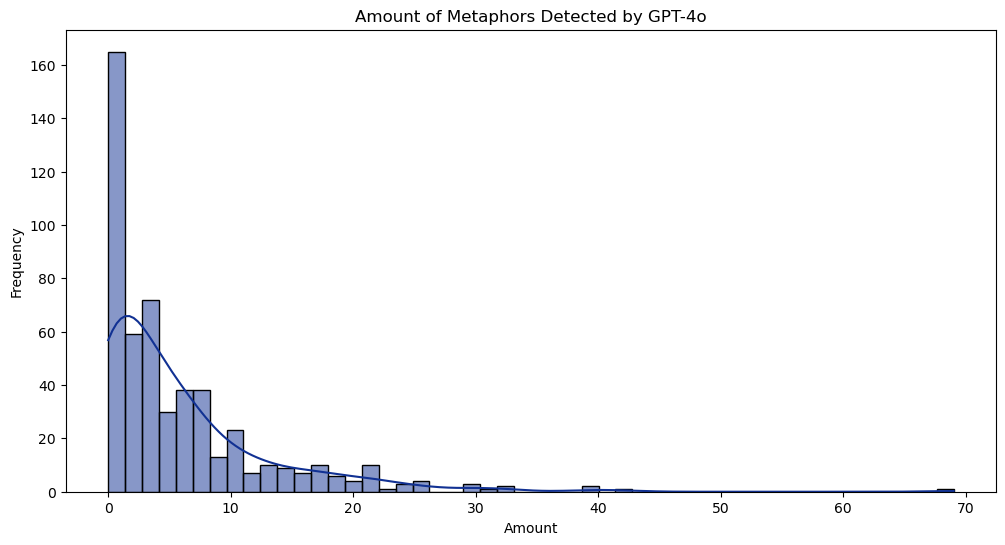

In [23]:
# Amount of Metaphors detected
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='GPT_Length', bins=50, kde=True, color=color)
plt.title('Amount of Metaphors Detected by GPT-4o')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


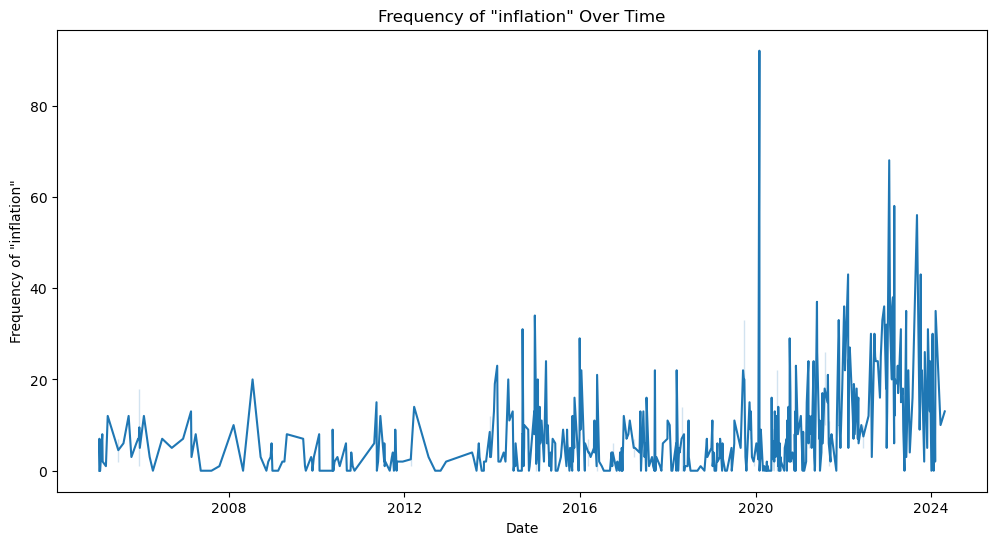

In [24]:
# Frequency of "inflation" Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Frequency')
plt.title('Frequency of "inflation" Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency of "inflation"')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


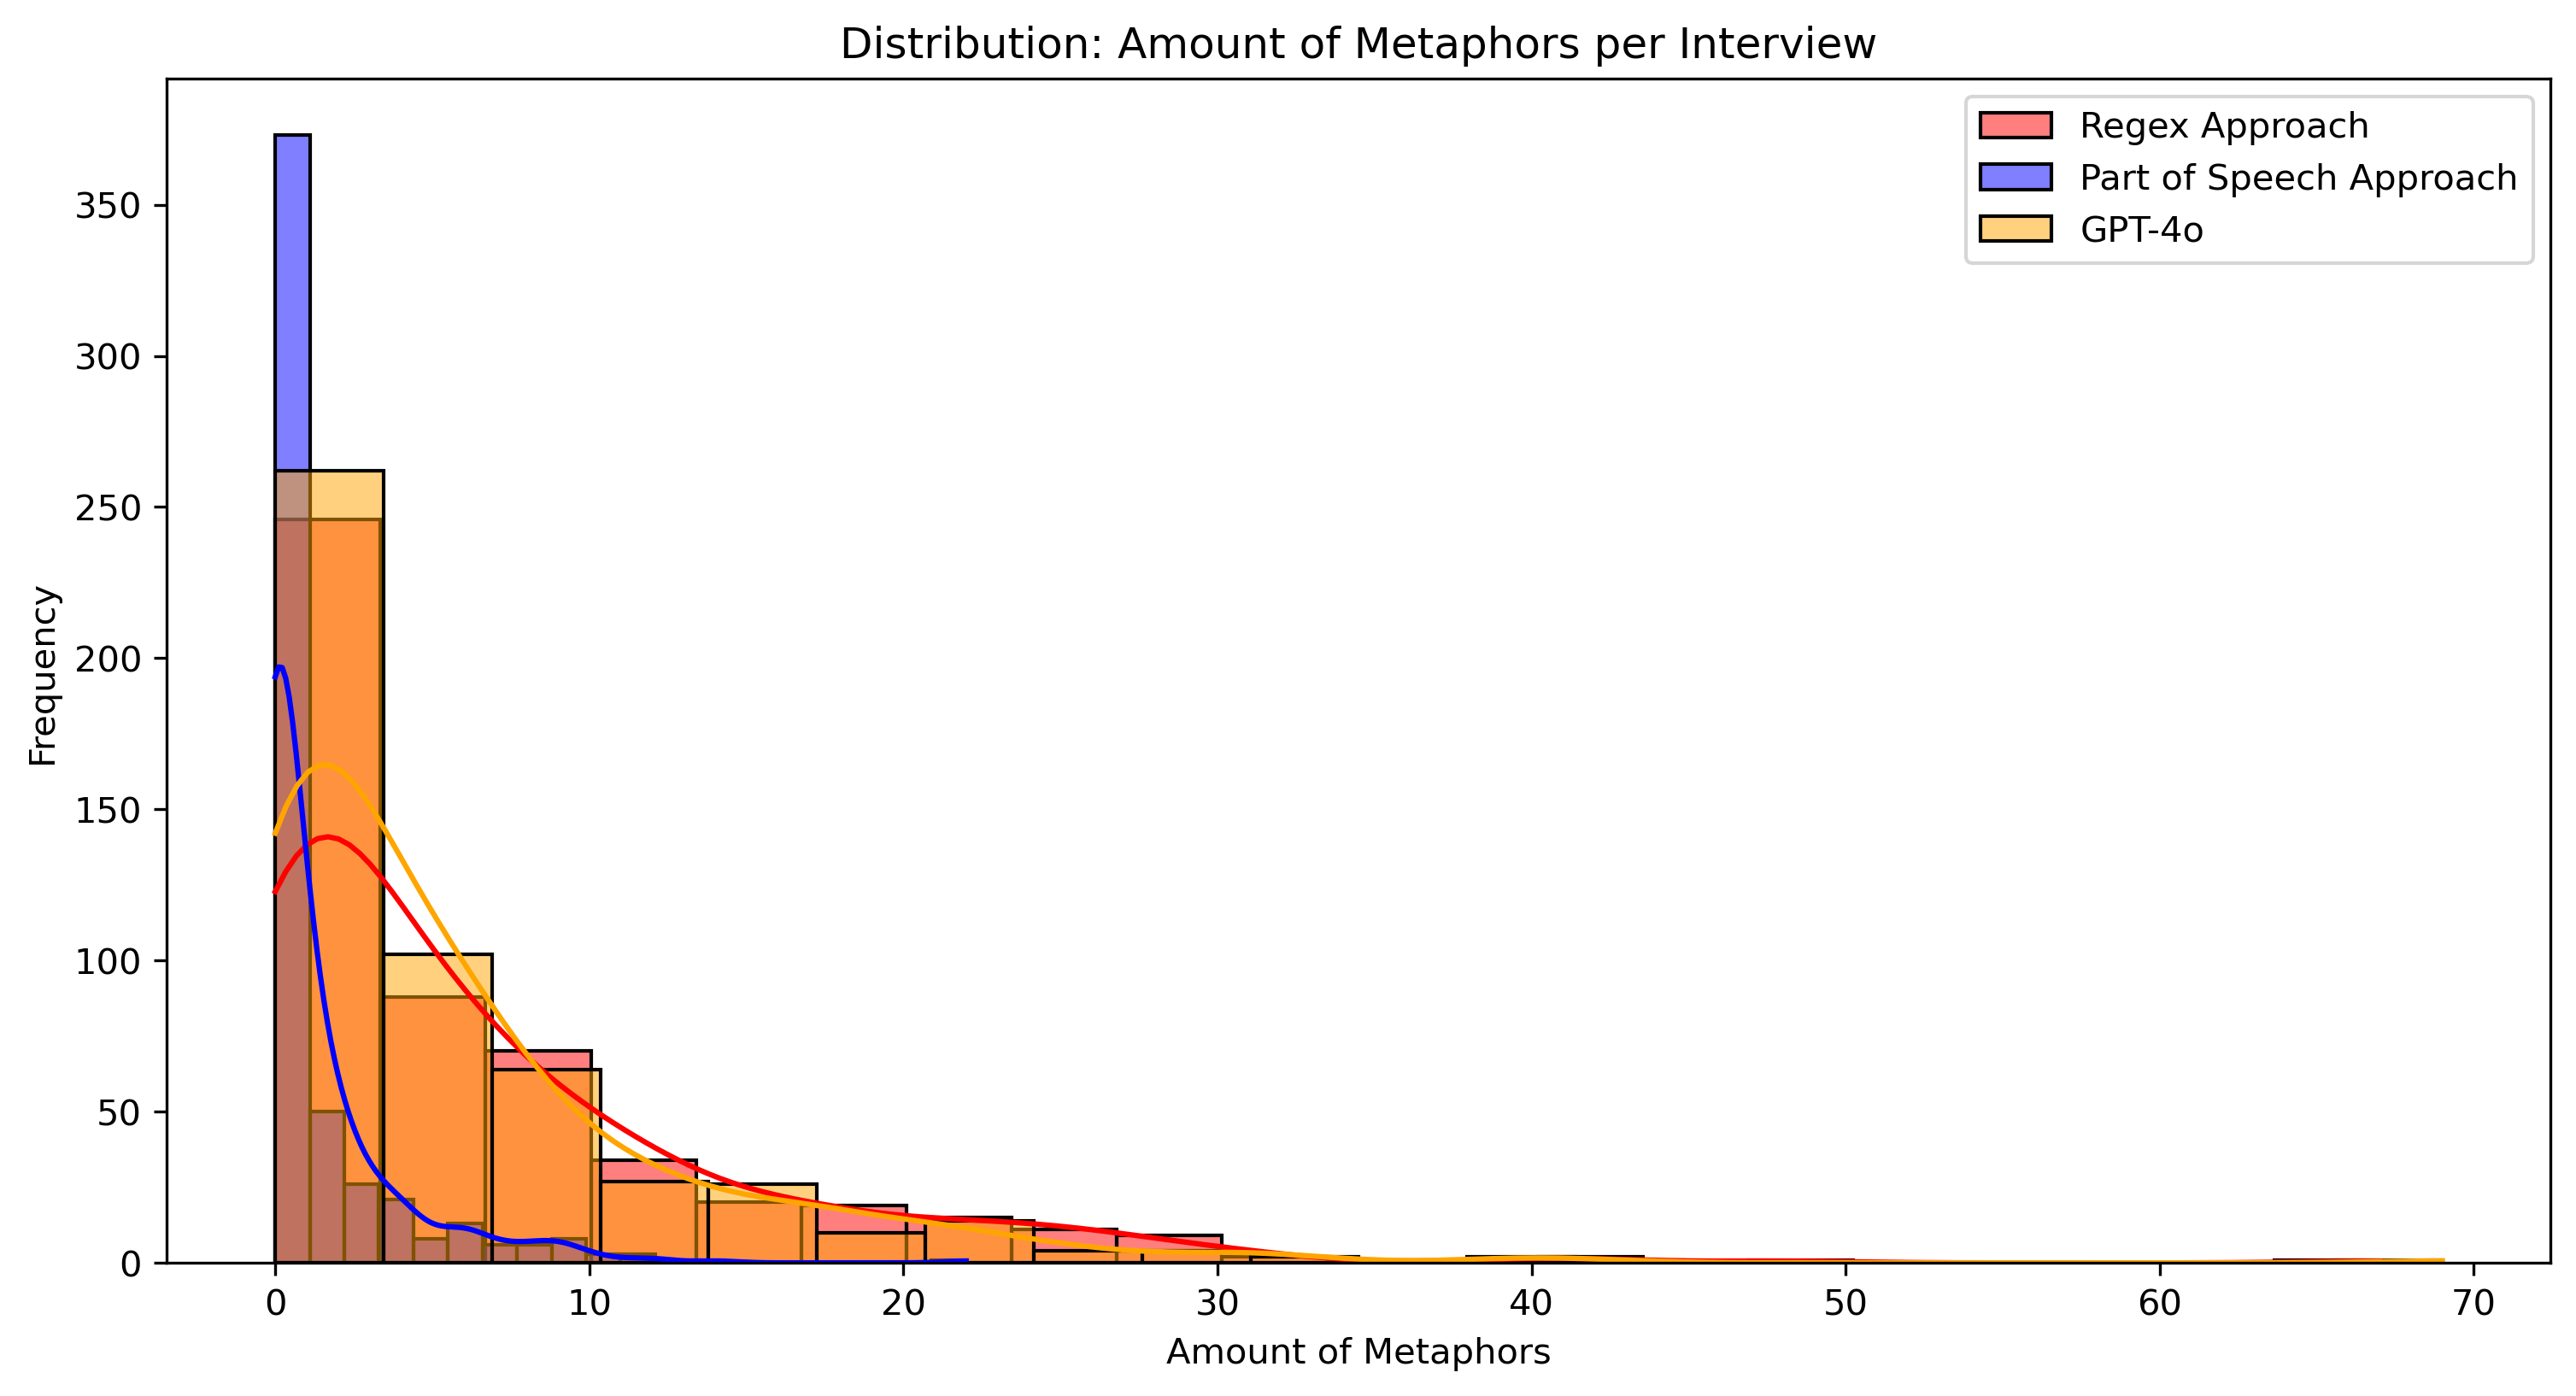

In [25]:
plt.figure(figsize=(12, 6),dpi=300)
sns.histplot(data=df, x='list_regex_reduced_len', bins=20, kde=True, color='red', label='Regex Approach')
sns.histplot(data=df, x='pos_metaphors_len', bins=20, kde=True, color='blue', label='Part of Speech Approach')
sns.histplot(data=df, x='GPT_Length', bins=20, kde=True, color='orange', label='GPT-4o')
plt.title('Distribution: Amount of Metaphors per Interview')
plt.xlabel('Amount of Metaphors')
plt.ylabel('Frequency')
plt.legend()
plt.show()

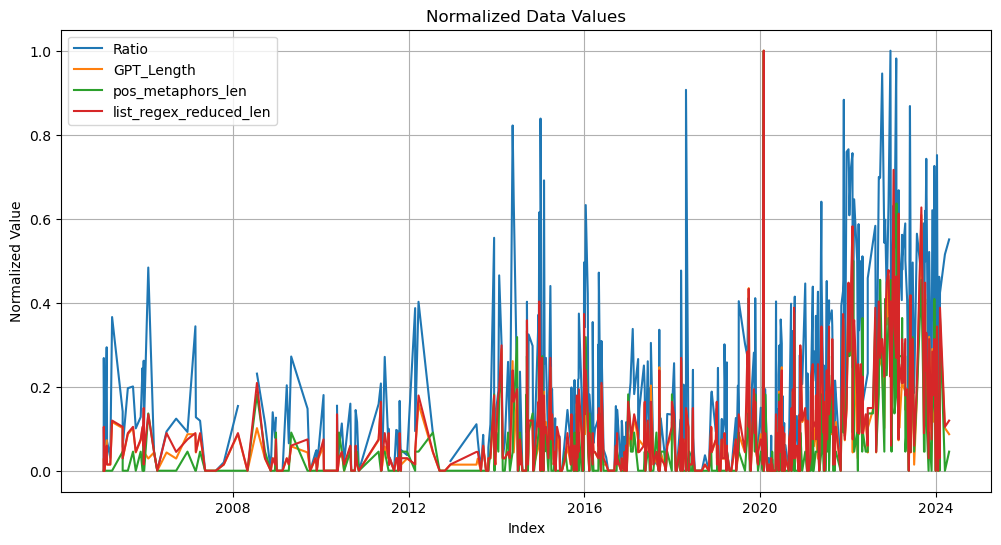

In [26]:
# Create a copy of the specified columns
columns_to_normalize = ['Date','Ratio','GPT_Length', 'pos_metaphors_len', 'list_regex_reduced_len']
df_copy = df[columns_to_normalize].copy()

# Set date as index
df_copy.set_index('Date', inplace=True)
# Ensure the DataFrame is sorted by date
df_copy.sort_index(inplace=True)

# Normalize the values in these columns
scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(df_copy)

# Create a DataFrame with normalized values, keeping the Date as index
df_normalized = pd.DataFrame(normalized_values, columns=df_copy.columns, index=df_copy.index)

# Plot normalized values against each other
plt.figure(figsize=(12, 6))

for column in df_normalized.columns:
    plt.plot(df_normalized.index, df_normalized[column], label=column)

# Customize the plot
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.title('Normalized Data Values')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

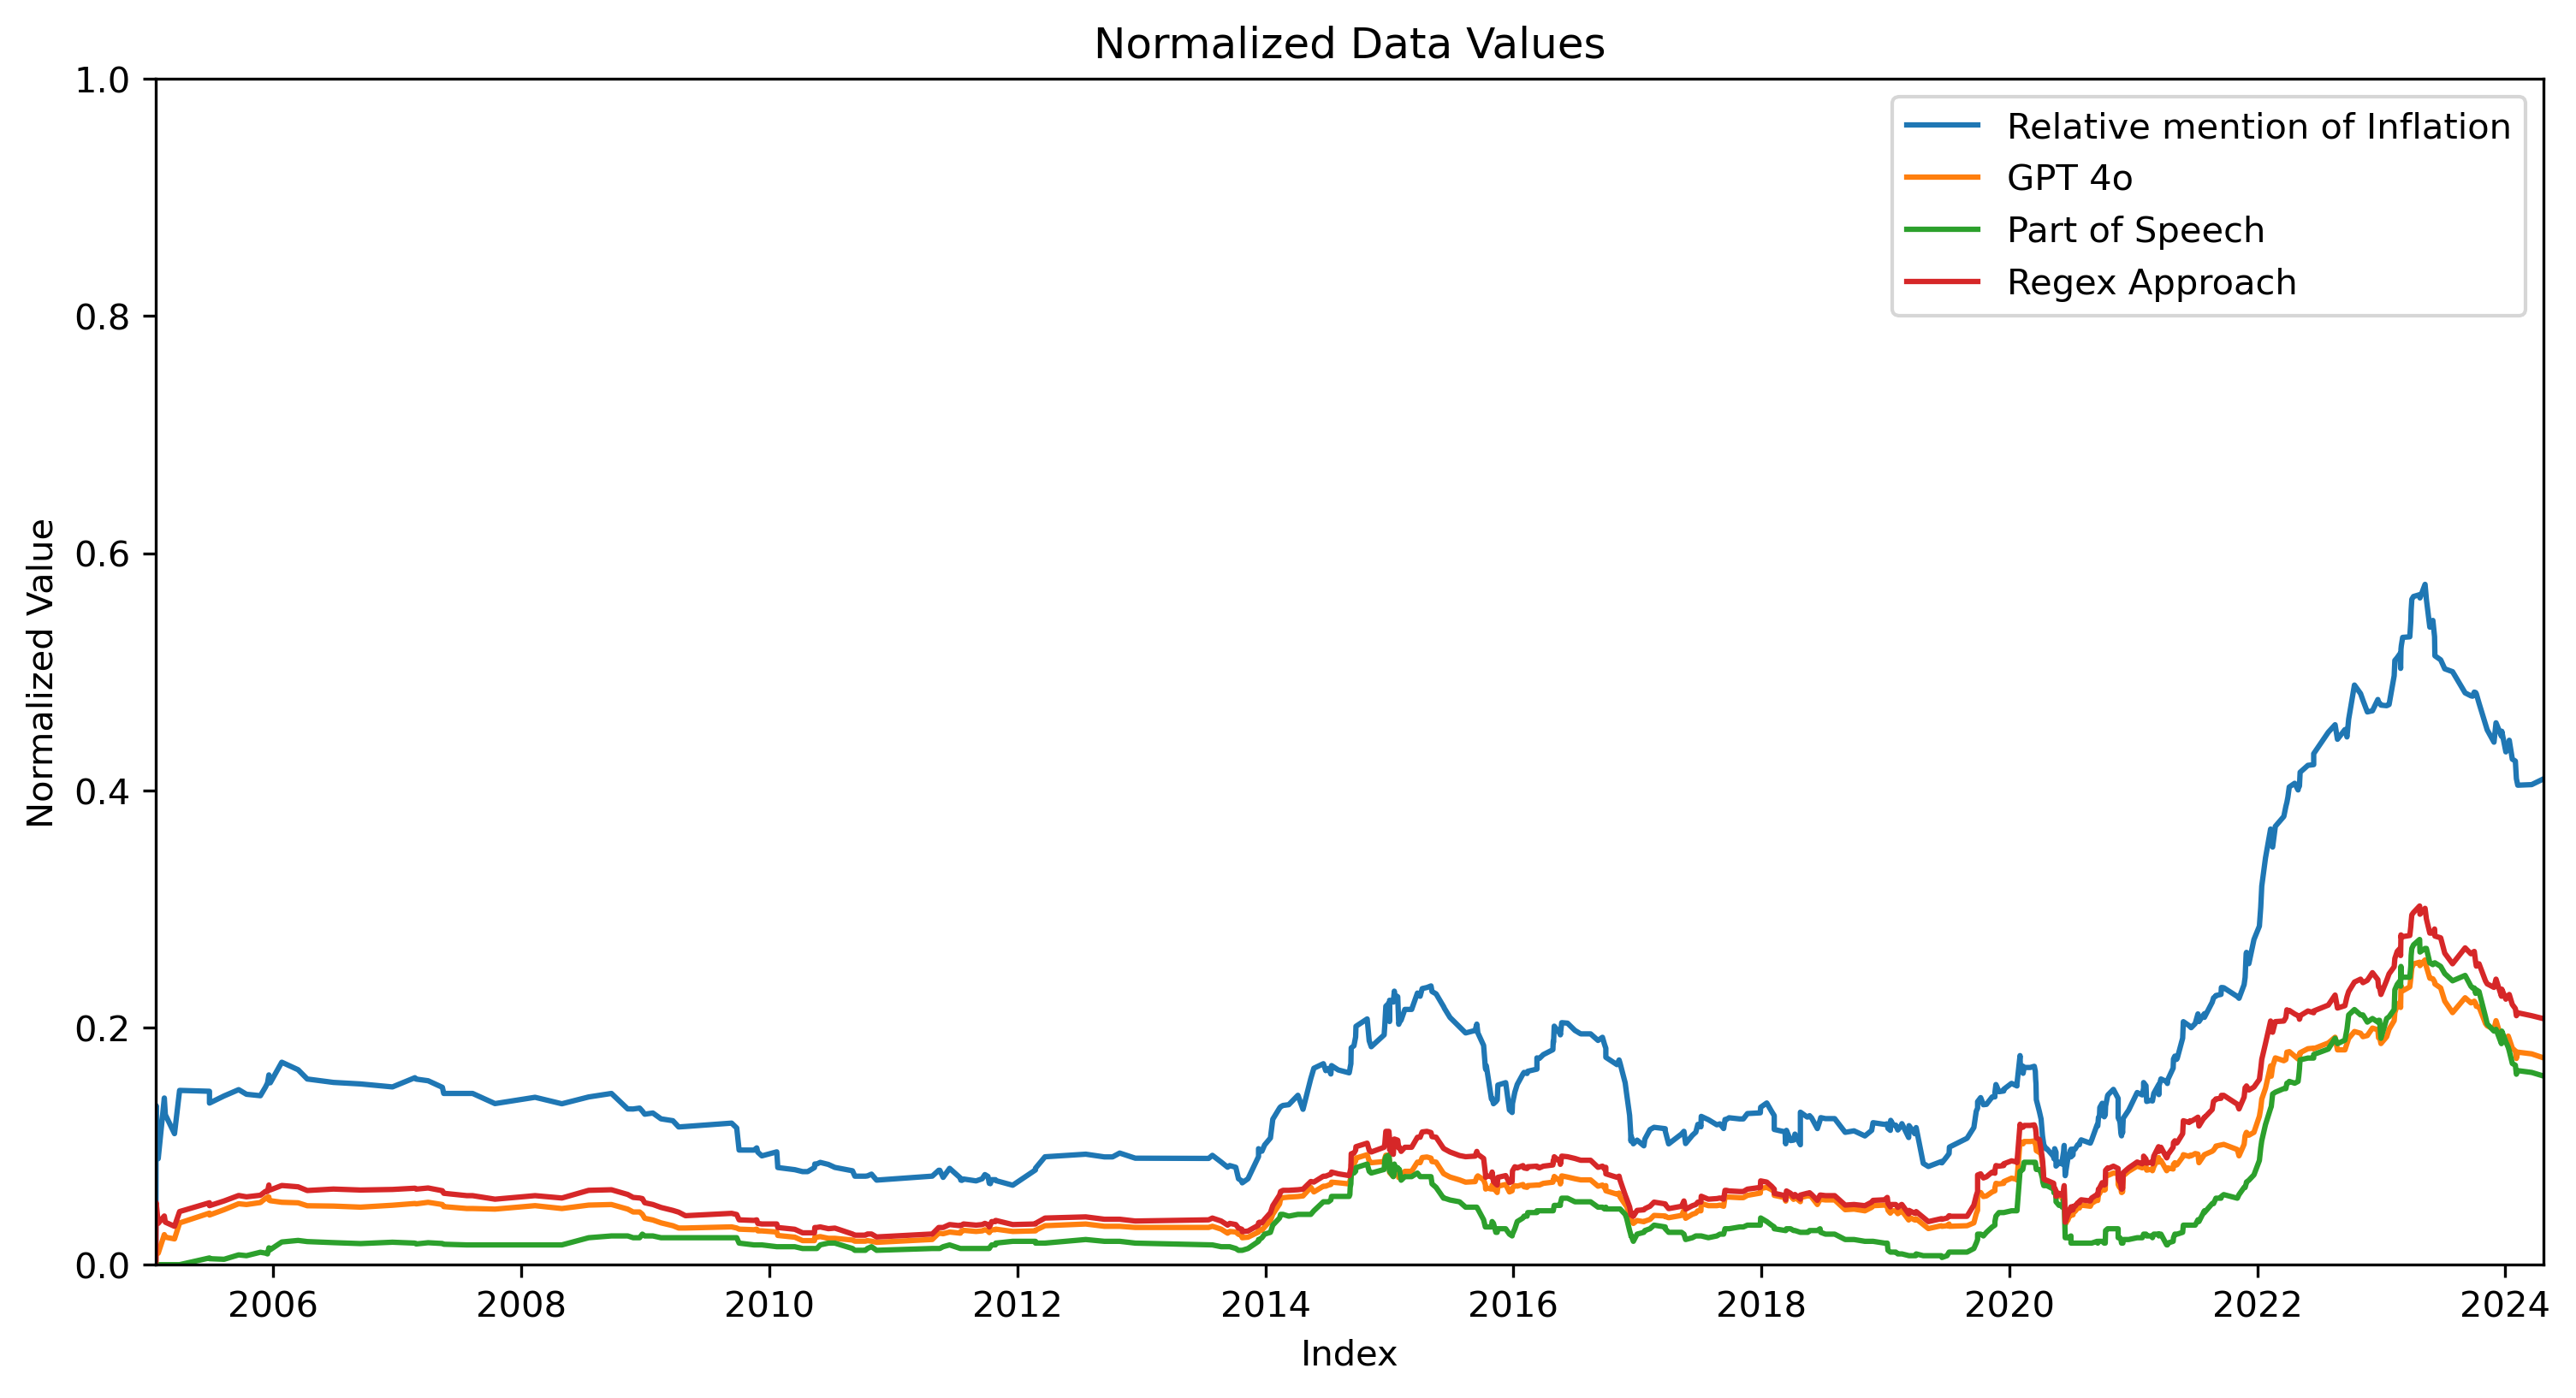

In [27]:
# Smooth plot:
def moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(12, 6),dpi=300)
# Apply moving average to smooth the lines
window_size = 30

col_names = ['Relative mention of Inflation' , 'GPT 4o', 'Part of Speech', 'Regex Approach']

for column in df_normalized.columns:
    plt.plot(df_normalized.index, moving_average(df_normalized[column], window_size), label=col_names.pop(0))


# Customize the plot
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.title('Normalized Data Values')
plt.legend()

# Set the x-axis and y-axis limits
plt.xlim(df_normalized.index.min(), df_normalized.index.max())
plt.ylim(0, 1)

# Display the plot
plt.show()

C:\Users\School\AppData\Local\Temp\ipykernel_3496\701852223.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
C:\Users\School\AppData\Local\Temp\ipykernel_3496\701852223.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color=cmap(norm(diff[i])))
C:\Users\School\AppData\Local\Temp\ipykernel_3496\701852223.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = pl

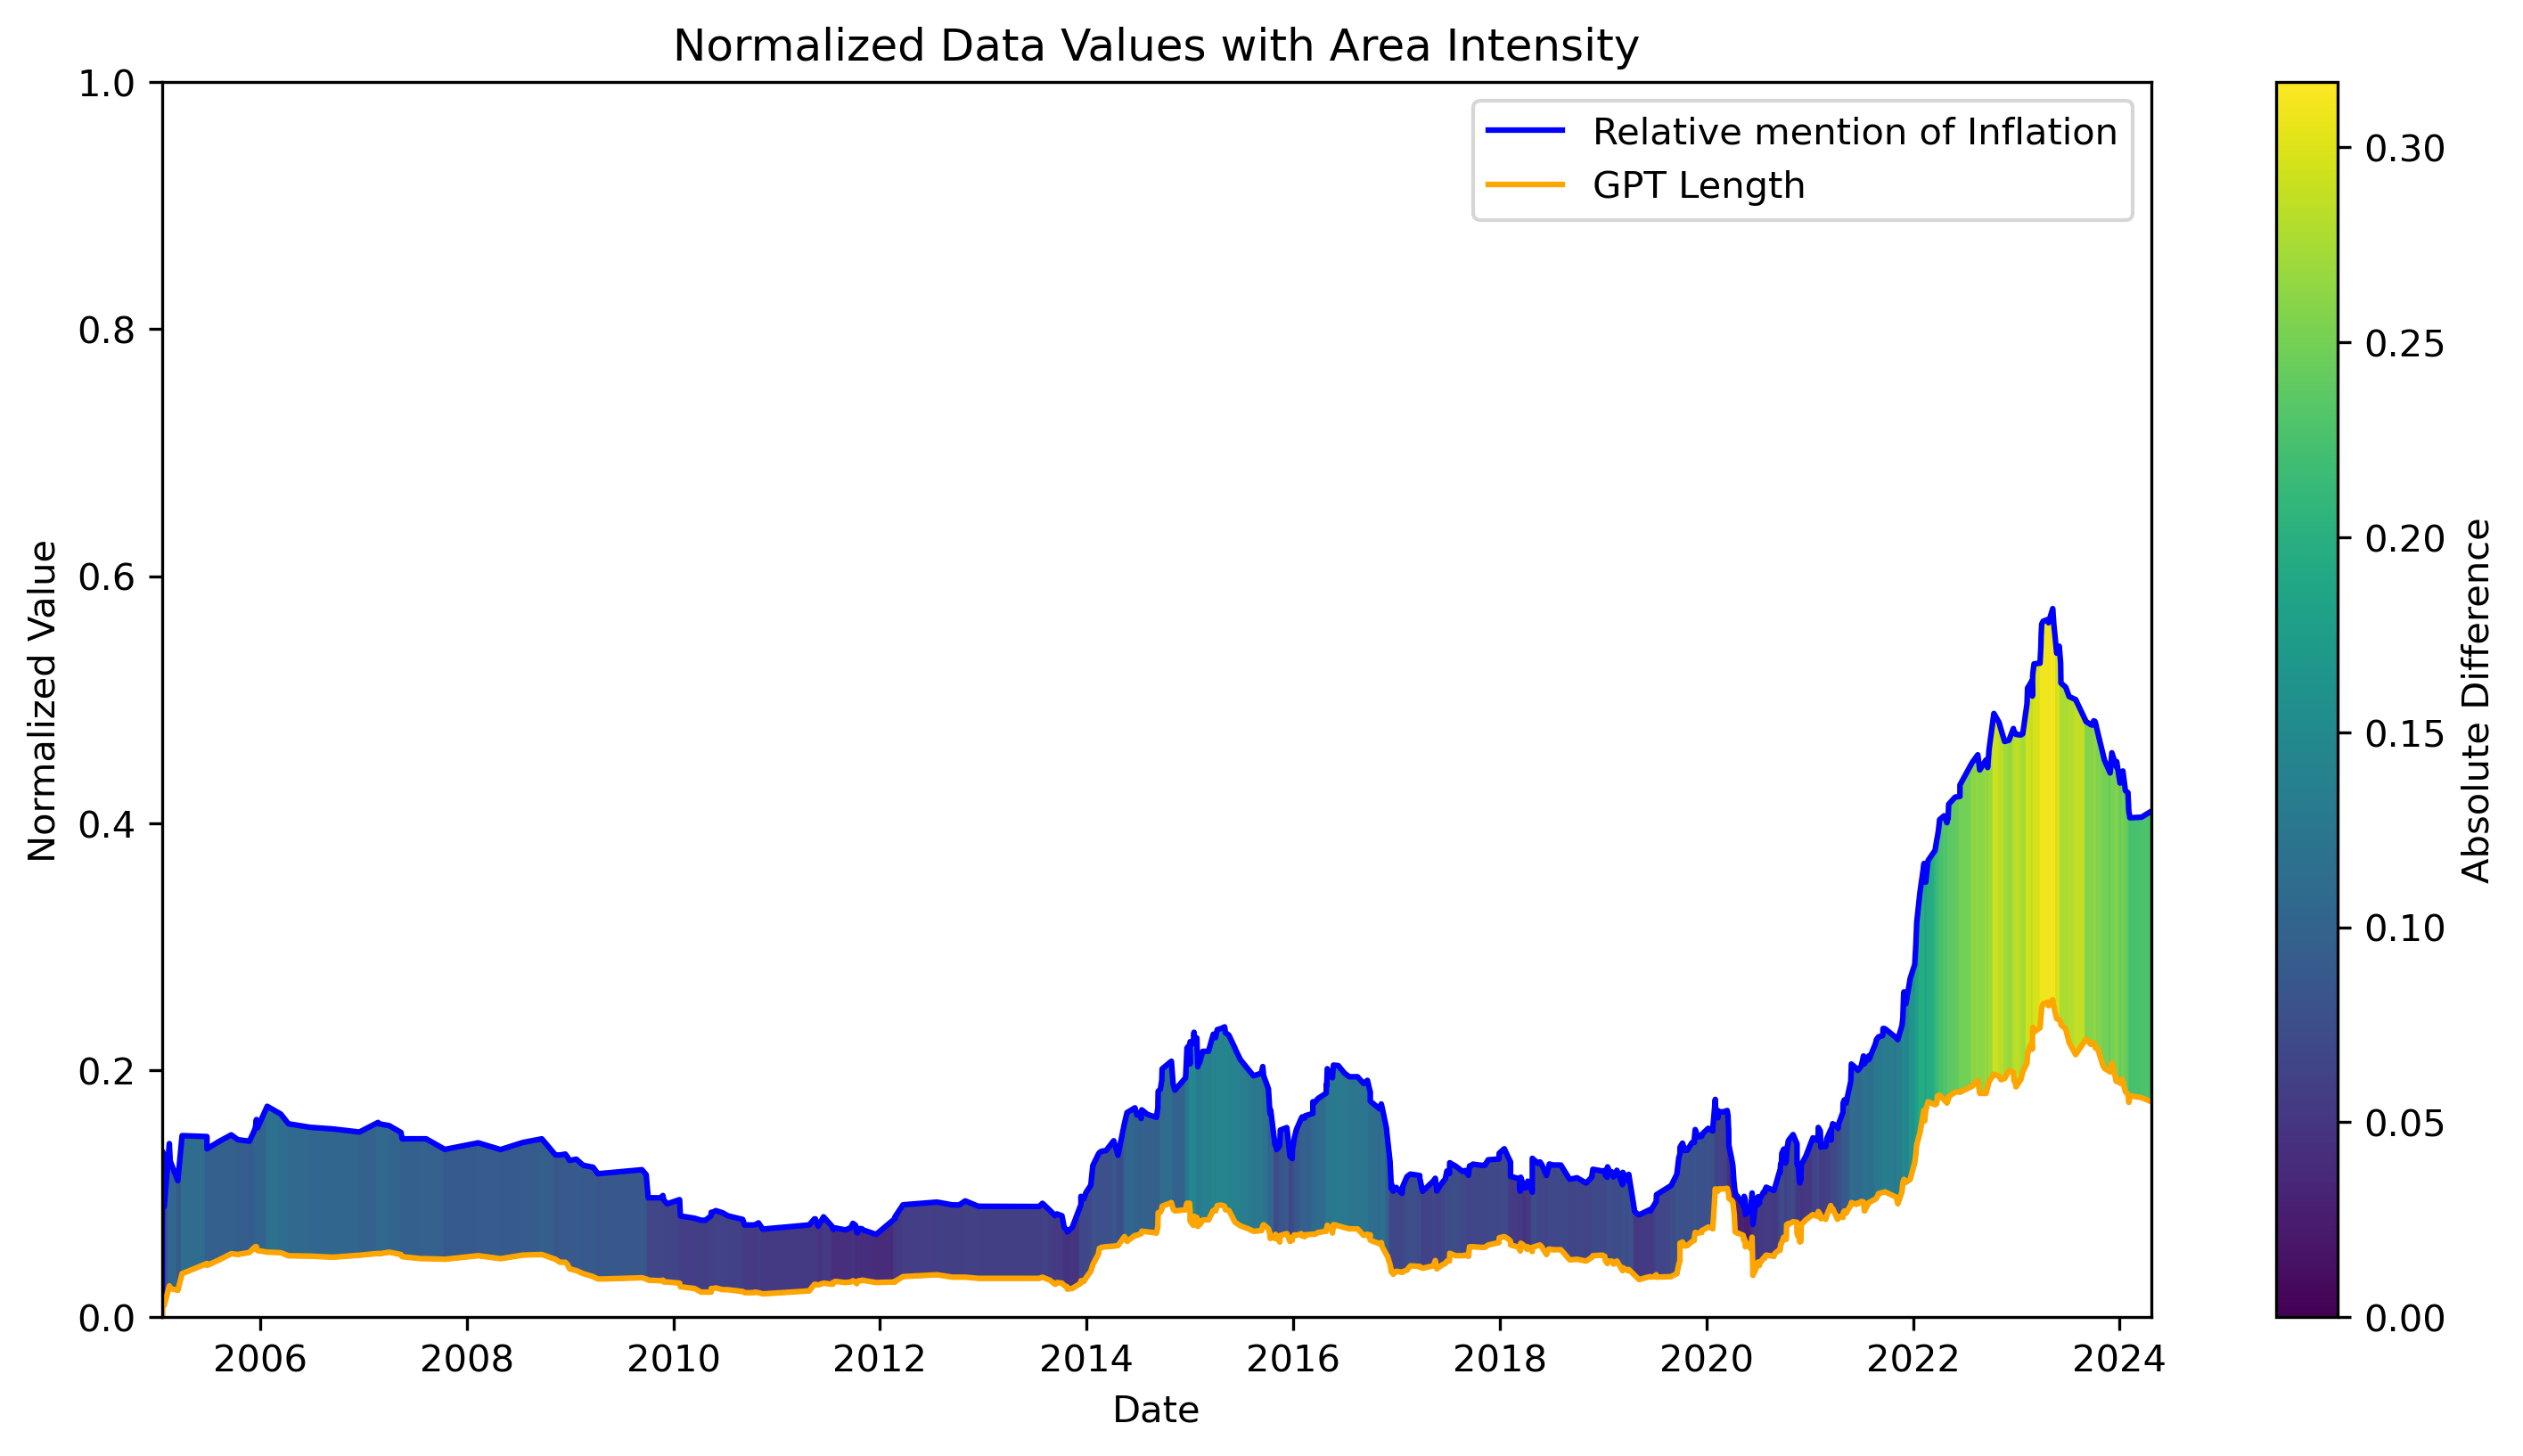

In [28]:
plt.figure(figsize=(12, 6), dpi=300)

# Apply moving average to smooth the lines
window_size = 30

def moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

ratio_smoothed = moving_average(df_normalized['Ratio'], window_size)
gpt_length_smoothed = moving_average(df_normalized['GPT_Length'], window_size)

# Calculate the absolute difference for coloring
diff = np.abs(ratio_smoothed - gpt_length_smoothed)
norm = Normalize(vmin=diff.min(), vmax=diff.max())
cmap = cm.get_cmap('viridis')

# Plot the smoothed lines
plt.plot(df_normalized.index, ratio_smoothed, label='Relative mention of Inflation', color='blue')
plt.plot(df_normalized.index, gpt_length_smoothed, label='GPT Length', color='orange')

# Fill the area between the lines with varying color intensity
for i in range(len(df_normalized) - 1):
    plt.fill_between(df_normalized.index[i:i+2],
                     ratio_smoothed[i:i+2],
                     gpt_length_smoothed[i:i+2],
                     color=cmap(norm(diff[i])))

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Absolute Difference')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title('Normalized Data Values with Area Intensity')
plt.legend()

# Set the x-axis and y-axis limits
plt.xlim(df_normalized.index.min(), df_normalized.index.max())
plt.ylim(0, 1)

# Display the plot
plt.show()


The values are normalized. A moving average of 30 days has been implemented to soomthen the line. 

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

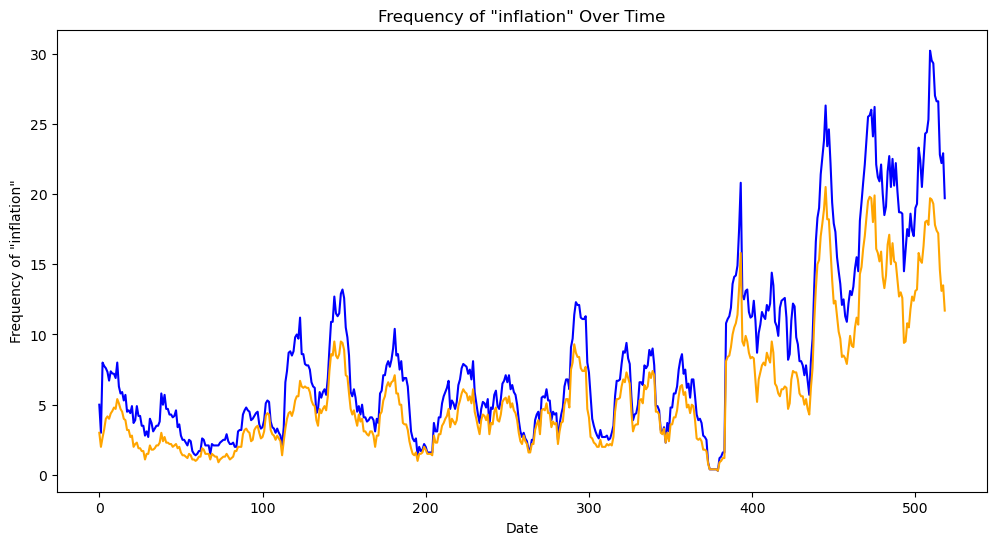

In [29]:
# Plot of Frequency of "inflation" Over Time with moving average
plt.figure(figsize=(12, 6))
window_size = 10
sns.lineplot(moving_average(df['Frequency'], window_size), color='blue')
sns.lineplot(moving_average(df['GPT_Length'], window_size), color='orange')
plt.title('Frequency of "inflation" Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency of "inflation"')
plt.show()

# EDA: Performance of each model

## Perfromance of the 4 different models in ideantifying metaphors

First we need to merge both datasets:
- Prediction_Data - containing the prediction from NN and LLM
- Final_Data - containing the extracted metaphors from Regex and POS

Both dataframes have different shapes, the first one has each sentence in different rows while the second one has each interview in different rows. 

In [ ]:
# TODO: Pie Chart of the Categories
# TODO: Compare "list_regex" and "list_regex_reduced" with GPT - Metrics !
# TODO: WordCloud Categories (Other vs Orientation vs ALL)
# TODO: Pie chart for the categories: Man vs Female, When Inflation is in bull market vs bear market

In [47]:
# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(df['list_regex_reduced_len'], df['GPT_Length'])
precision = precision_score(df['list_regex_reduced_len'], df['GPT_Length'], average='weighted')
recall = recall_score(df['list_regex_reduced_len'], df['GPT_Length'], average='weighted')
f1 = f1_score(df['list_regex_reduced_len'], df['GPT_Length'], average='weighted')

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.6878612716763006
Precision: 0.6810091533106547
Recall: 0.6878612716763006
F1 Score: 0.6752970776379003


C:\Users\School\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\School\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(df['pos_relationships_len'], df['GPT_Length'])
precision = precision_score(df['pos_relationships_len'], df['GPT_Length'], average='weighted')
recall = recall_score(df['pos_relationships_len'], df['GPT_Length'], average='weighted')
f1 = f1_score(df['pos_relationships_len'], df['GPT_Length'], average='weighted')

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.30057803468208094
Precision: 0.4380138462294944
Recall: 0.30057803468208094
F1 Score: 0.3529744083753982


C:\Users\School\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\School\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
df.head()

Unnamed: 0       Date                                              Media  \
0           0 2005-12-23                         Interview with Der Spiegel   
1           1 2005-12-19                  Interview with Hospodářské Noviny   
2           2 2005-12-19  Interview with Financial Times and Financial T...   
3           3 2005-12-15                         Interview with Paris Match   
4           4 2005-12-09                           Interview in Il Giornale   

                Member                                               Link  \
0  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/200...   
1         Otmar Issing  https://www.ecb.europa.eu/press/inter/date/200...   
2      Lucas Papademos  https://www.ecb.europa.eu/press/inter/date/200...   
3  Jean-Claude Trichet  https://www.ecb.europa.eu/press/inter/date/200...   
4  Lorenzo Bini Smaghi  https://www.ecb.europa.eu/press/inter/date/200...   

             Information                                          Questions  \
0  Information not found  SPIEGEL: Monsieur Trichet, any concrete uttera...   
1  Information not found  The new EU member states want to adopt the eur...   
2  Information not found  Mr Papademos, you have responsibility as ECB V...   
3  Information not found  Paris Match. After two uneventful years at the...   
4  Information not found  However, Europe’s politicians, with few except...   

                                             Answers Metaphors  \
0  The publication of the translation was authori...       NaN   
1  These questions are all closely related to eac...       NaN   
2  A comparison of the risks involved when short-...       NaN   
3  The publication of the translation was authori...       NaN   
4  By Angelo Allegri, our correspondent in Frankf...       NaN   

  Metaphors Sentence  ...  Sentences_len  \
0                NaN  ...              3   
1                NaN  ...              1   
2                NaN  ...             11   
3                NaN  ...              5   
4                NaN  ...              7   

                               Sentence_GPT_Majority  \
0  [we will in the future take the decisions that...   
1  [we are not confronted with deflation but with...   
2  [in the us the policy stance changed and the d...   
3  [furthermore we must not wait until inflation ...   
4  [the rise has helped to keep inflation expecta...   

                               GPT_Majority_Category  \
0                    ['machine', 'disease', 'plant']   
1                                        ['warfare']   
2                   ['fire', 'fire', 'fire', 'fire']   
3  ['warfare', 'disease', 'disease', 'machine', '...   
4  ['orientation', 'orientation', 'orientation', ...   

                            Matched_Metaphors  \
0                          [True, True, True]   
1                                      [True]   
2                    [True, True, True, True]   
3              [True, True, True, True, True]   
4  [True, True, True, True, True, True, True]   

                                   pos_relationships  \
0  [('inflationary', 'expectation'), ('inflation'...   
1                                                 []   
2  [('future', 'inflation'), ('low', 'inflation')...   
3  [('inflationary', 'remain'), ('inflationary', ...   
4                          [('inflation', 'regard')]   

                                       pos_sentences  pos_relationships_len  \
0                                                 []                      3   
1                                                 []                      0   
2  ['it a higher level of interest rates could fo...                      8   
3                                                 []                      2   
4                                                 []                      1   

                               Category_GPT_Majority  GPT_Length     Ratio  
0                    ['machine', 'disease', 'plant']           3  0.00

In [30]:
df.shape

(519, 33)

In [31]:
df_pred = pd.read_csv('Data/Prediction_Data.csv')
df_pred.shape

(3437, 5)

In [32]:
df_pred.head()

Sentence  Matched Category  \
0  We will in the future take the decisions that ...     True  machine   
1  This is a risk which in turn would affect infl...     True  disease   
2  Our decision by stabilising inflationary expec...     True    plant   
3  We are not confronted with deflation but with ...     True  warfare   
4  If longterm interest rates remain at a low lev...    False      NaN   

   Predicted_NN  Predicted_LLM  
0          True           True  
1          True           True  
2          True           True  
3          True           True  
4         False          False

In [41]:
df_pred["Sentence"].head()

0    We will in the future take the decisions that ...
1    This is a risk which in turn would affect infl...
2    Our decision by stabilising inflationary expec...
3    We are not confronted with deflation but with ...
4    If longterm interest rates remain at a low lev...
Name: Sentence, dtype: object

In [34]:
df.columns

Index(['Unnamed: 0', 'Date', 'Media', 'Member', 'Link', 'Information',
       'Questions', 'Answers', 'Metaphors', 'Metaphors Sentence', 'YoB',
       'Gender', 'Country', 'Period on the Board', 'list_regex',
       'list_regex_reduced', 'list_regex_len', 'list_regex_reduced_len',
       'text_length', 'pos_metaphors', 'pos_metaphors_len', 'Sentences',
       'Frequency', 'Sentences_len', 'Sentence_GPT_Majority',
       'GPT_Majority_Category', 'Matched_Metaphors', 'pos_relationships',
       'pos_sentences', 'pos_relationships_len', 'Category_GPT_Majority',
       'GPT_Length', 'Ratio'],
      dtype='object')

In [37]:
df["list_regex_reduced"].head(17)

0     ['we will in the future take the decision that...
1     ['we be not confront with deflation but with i...
2     ['if longterm interest rate remain at a low le...
3     ['you be exaggerate the increase in the cost o...
4     ['the rise have help to keep inflation expecta...
5     ['a it be important that price rise today do n...
6     ['that be the reason why the inflation expecta...
7     ['it be the job of the ecb Governing Council t...
8     ['the impact that the price of oil have on inf...
9     ['first a stabilityoriented monetary policy wh...
10    ['adjust for inflation they be practically nea...
11    ['our late assessment confirm that underlie in...
12    ["costgenerate inflation tend to rise and that...
13    ['compare to the early part of it seem that Ch...
14    ['economic analysis do not point to inflationa...
15                                                   []
16    ['our objective be price stability we aim at a...
Name: list_regex_reduced, dtype: object

In [38]:
df["pos_metaphors"]

0                                                     []
1                                                     []
2       [('low', 'inflation'), ('current', 'inflation')]
3                                                     []
4                                                     []
                             ...                        
514    [('inflation', 'fight'), ('inflation', 'reduce...
515                                                   []
516    [('core', 'inflation'), ('high', 'inflation'),...
517    [('inflation', 'fall'), ('inflation', 'ease'),...
518                                                   []
Name: pos_metaphors, Length: 519, dtype: object

In [ ]:
# 1 Preprocess df_pred sentence
# 2 Match 

# Sentiment Analysis of the Metaphors:

We will use a pre-trained LLM to evaluate the sentiment of the Metaphors.

In [38]:
# Load the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# "text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
# Tried other model: https://huggingface.co/models?pipeline_tag=text-classification&sort=trending
# Other models had approximately the same values. 

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [31]:
# Function to get sentiment scores for each sentence
def get_sentiment_scores(sentences):
    scores = []
    for sentence in sentences:
        result = sentiment_pipeline(sentence)
        scores.append(result[0]['score'] if result else 0)
    return scores

# Apply the function to each row in the dataframe
df['Sentiment_Scores'] = df['Sentence_GPT'].apply(get_sentiment_scores)

In [32]:
# Number of sentence_gpt with empty lists
empty_lists = df['Sentiment_Scores'].apply(len) == 0
print(f'Number of empty lists: {empty_lists.sum()}')   
# Number of sentiment scores with empty lists
empty_lists = df['Sentiment_Scores'].apply(len) == 0
print("Number of sentiment scores with empty lists: ", empty_lists.sum())

Number of empty lists: 118
Number of sentiment scores with empty lists:  118


c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a f

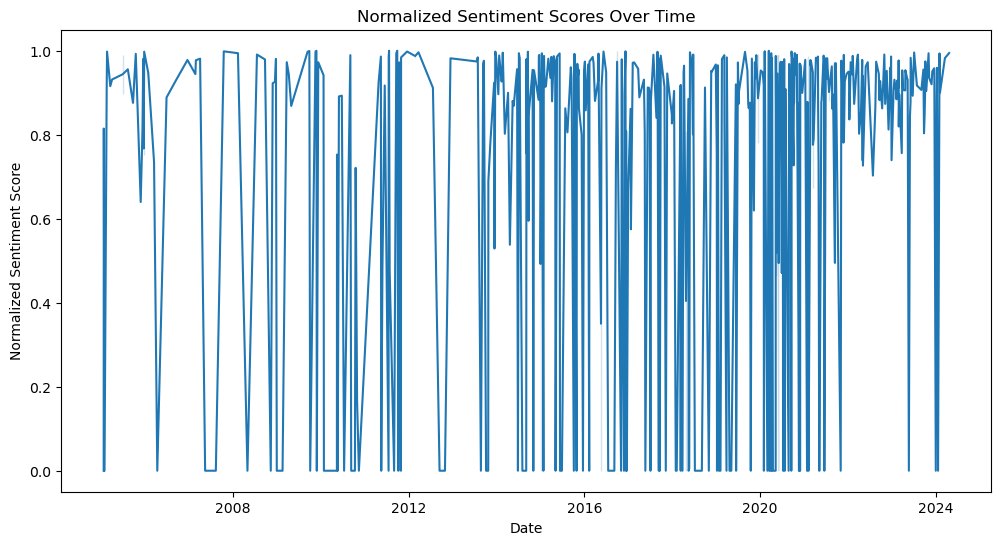

In [33]:
# average sentiment score
df['Average_Sentiment'] = df['Sentiment_Scores'].apply(np.mean)

# standard deviation of sentiment scores
df['Sentiment_Std'] = df['Sentiment_Scores'].apply(np.std)

# Normalize the sentiment scores
df['Normalized_Sentiment'] = (df['Average_Sentiment'] - df['Average_Sentiment'].min()) / (df['Average_Sentiment'].max() - df['Average_Sentiment'].min())
df['Normalized_Sentiment'] = df['Normalized_Sentiment'].fillna(0)

# Plot the normalized sentiment scores
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Normalized_Sentiment')
plt.title('Normalized Sentiment Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Sentiment Score')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


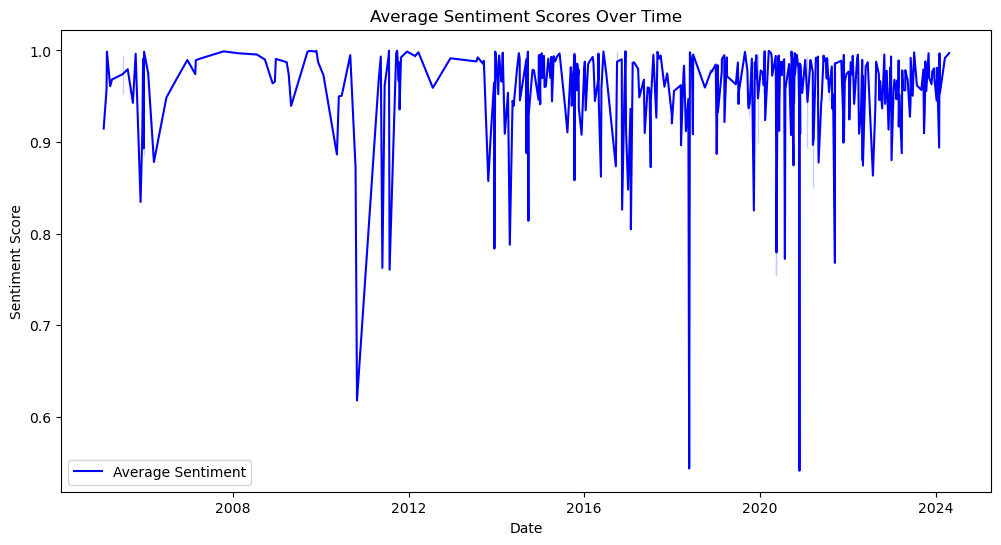

In [34]:
# Plot the average sentiment score over time and the standard deviation
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Average_Sentiment', color='blue', label='Average Sentiment')
plt.title('Average Sentiment Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


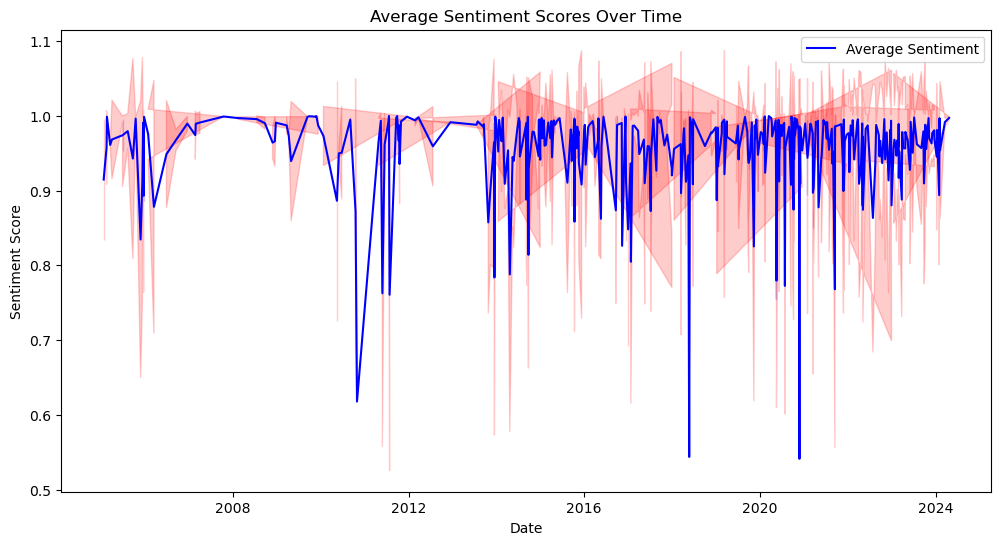

In [35]:
# Plot the average sentiment score over time and the standard deviation as confidence interval
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Average_Sentiment', color='blue', label='Average Sentiment')
plt.fill_between(df['Date'], df['Average_Sentiment'] - df['Sentiment_Std'], df['Average_Sentiment'] + df['Sentiment_Std'], color='red', alpha=0.2)
plt.title('Average Sentiment Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

C:\Users\School\AppData\Local\Temp\ipykernel_21108\2745138746.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
C:\Users\School\AppData\Local\Temp\ipykernel_21108\2745138746.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))


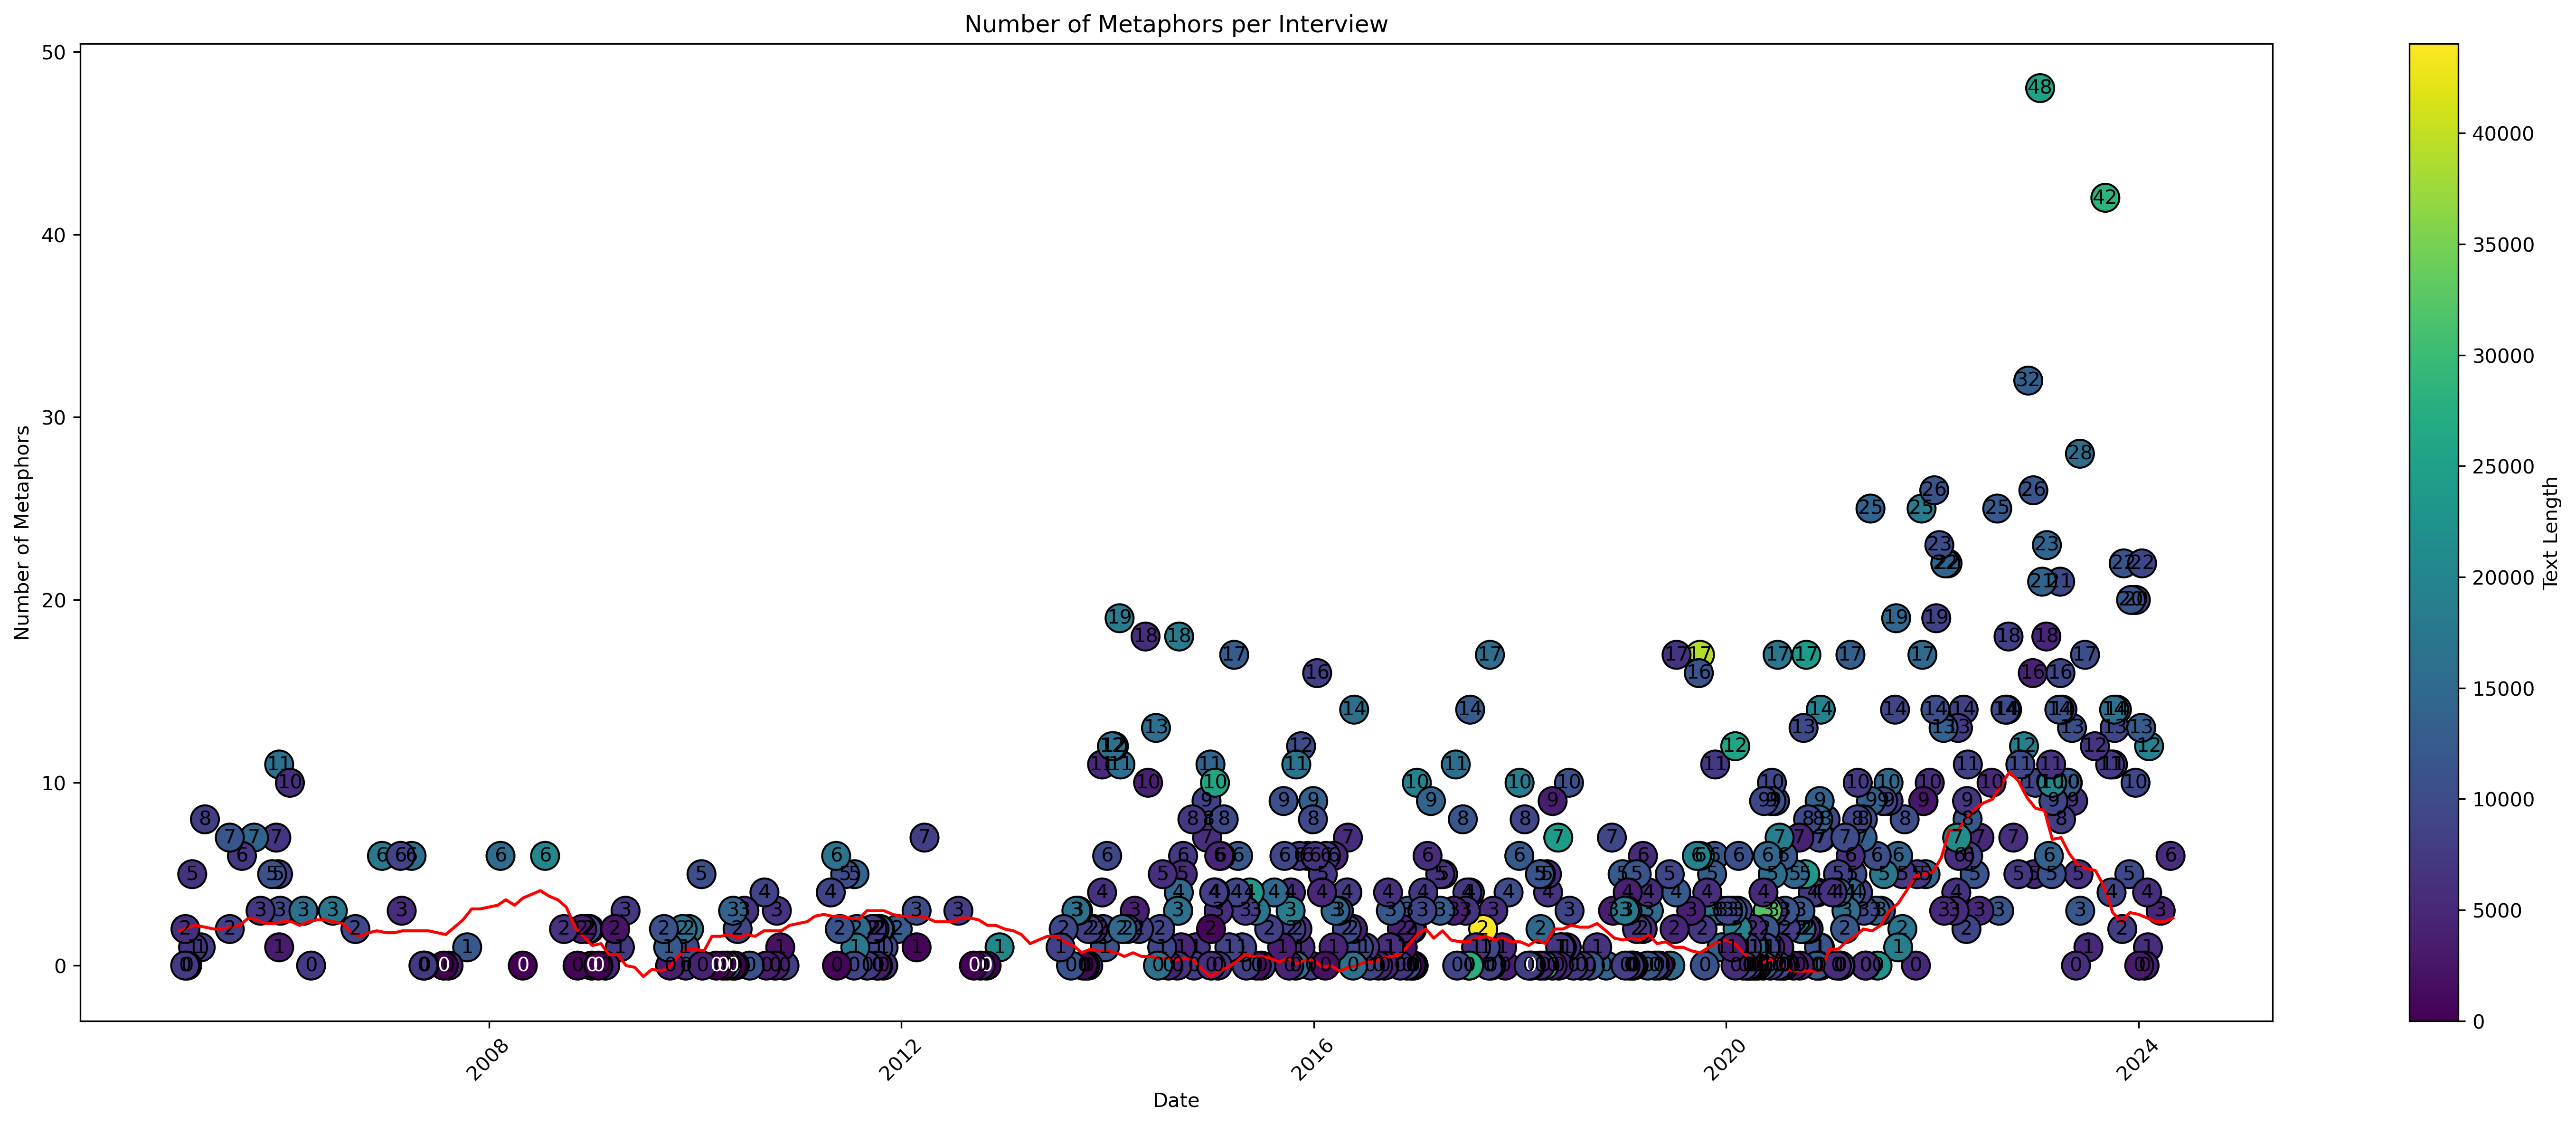

In [36]:
# Defining colors based on text length
norm = mcolors.Normalize(vmin=df['text_length'].min(), vmax=df['text_length'].max())
cmap = plt.cm.get_cmap('viridis')

# Create scatter plot
plt.figure(figsize=(20, 8), dpi=300)
sc = plt.scatter(df['Date'], df['GPT_Length'], c=df['text_length'], cmap=cmap, norm=norm, s=200, edgecolors='k')

# Add text length colorbar
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Text Length')

# Add metaphor count labels inside the points
for i, row in df.iterrows():
    plt.text(row['Date'], row['GPT_Length'], str(row['GPT_Length']), ha='center', va='center', color='white' if row['text_length'] < 0.5 else 'black')

# Plot line for OBS_VALUE from df2
plt.plot(df2['TIME_PERIOD'], df2['OBS_VALUE'], color='red', label='OBS_VALUE')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Number of Metaphors')
plt.title('Number of Metaphors per Interview')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

C:\Users\School\AppData\Local\Temp\ipykernel_21108\3220626128.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
C:\Users\School\AppData\Local\Temp\ipykernel_21108\3220626128.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))


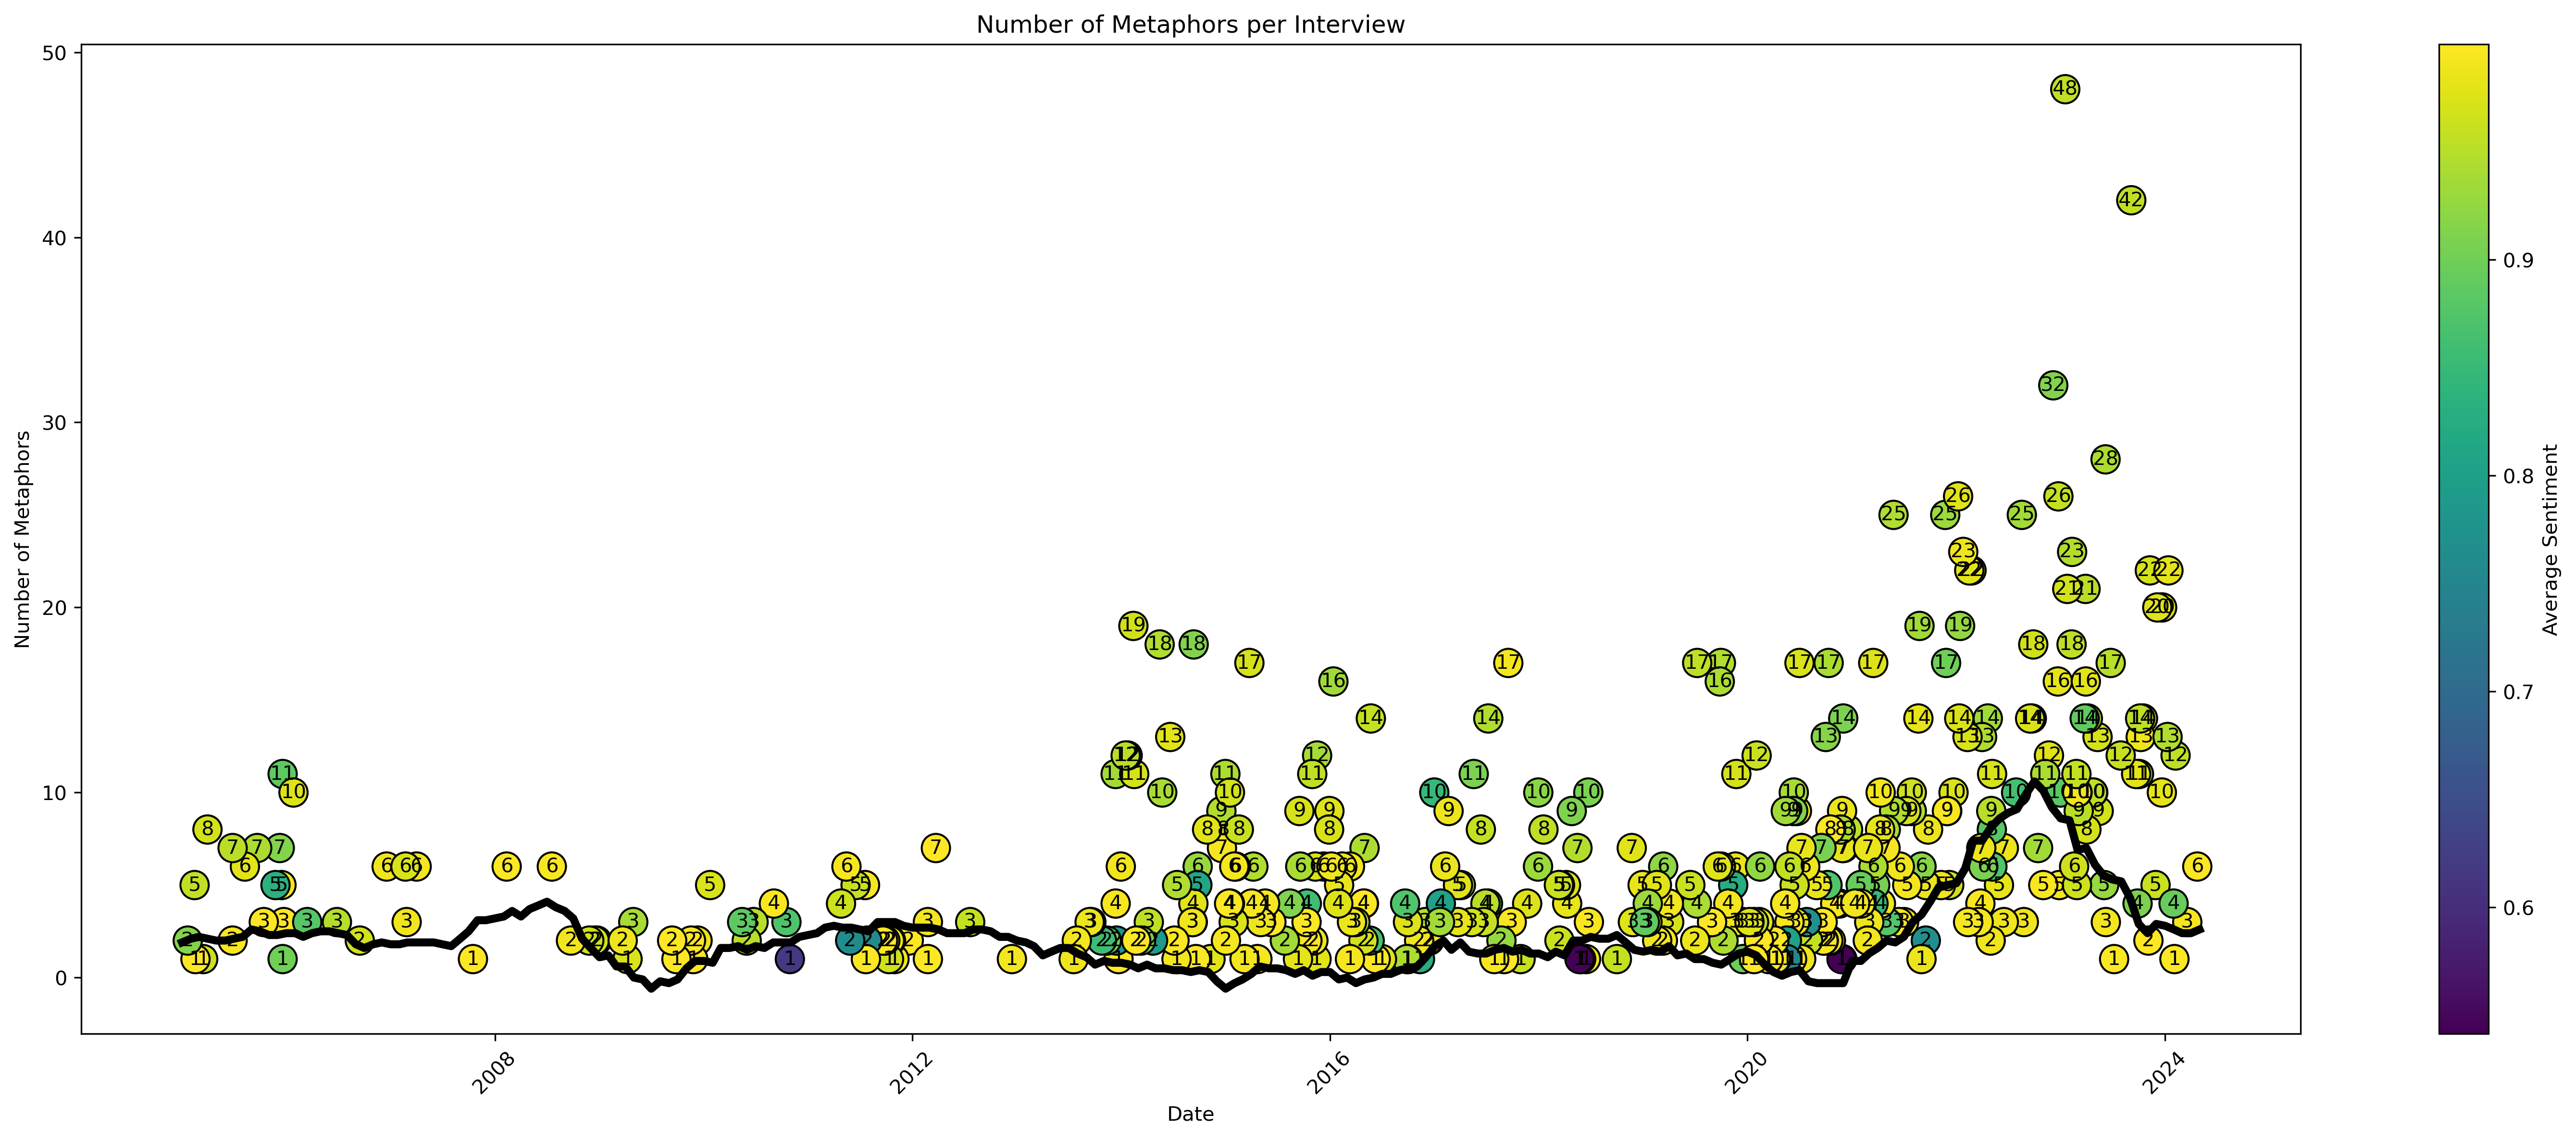

In [50]:
# Filter out rows where GPT_Length is 0
df_filtered = df[df['GPT_Length'] != 0]

# Defining colors based on text length
norm = mcolors.Normalize(vmin=df_filtered['Average_Sentiment'].min(), vmax=df_filtered['Average_Sentiment'].max())
cmap = plt.cm.get_cmap('viridis')

# Create scatter plot
plt.figure(figsize=(20, 8), dpi=300)
sc = plt.scatter(df_filtered['Date'], df_filtered['GPT_Length'], c=df_filtered['Average_Sentiment'], cmap=cmap, norm=norm, s=200, edgecolors='k')

# Add text length colorbar
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Average Sentiment')

# Add metaphor count labels inside the points
for i, row in df_filtered.iterrows():
    plt.text(row['Date'], row['GPT_Length'], str(row['GPT_Length']), ha='center', va='center', color='white' if row['Average_Sentiment'] < 0.5 else 'black')

# Plot line for OBS_VALUE from df2 with a thicker line
plt.plot(df2['TIME_PERIOD'], df2['OBS_VALUE'], color='black', label='OBS_VALUE', linewidth=4)

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Number of Metaphors')
plt.title('Number of Metaphors per Interview')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


C:\Users\School\AppData\Local\Temp\ipykernel_21108\1775893404.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
C:\Users\School\AppData\Local\Temp\ipykernel_21108\1775893404.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))


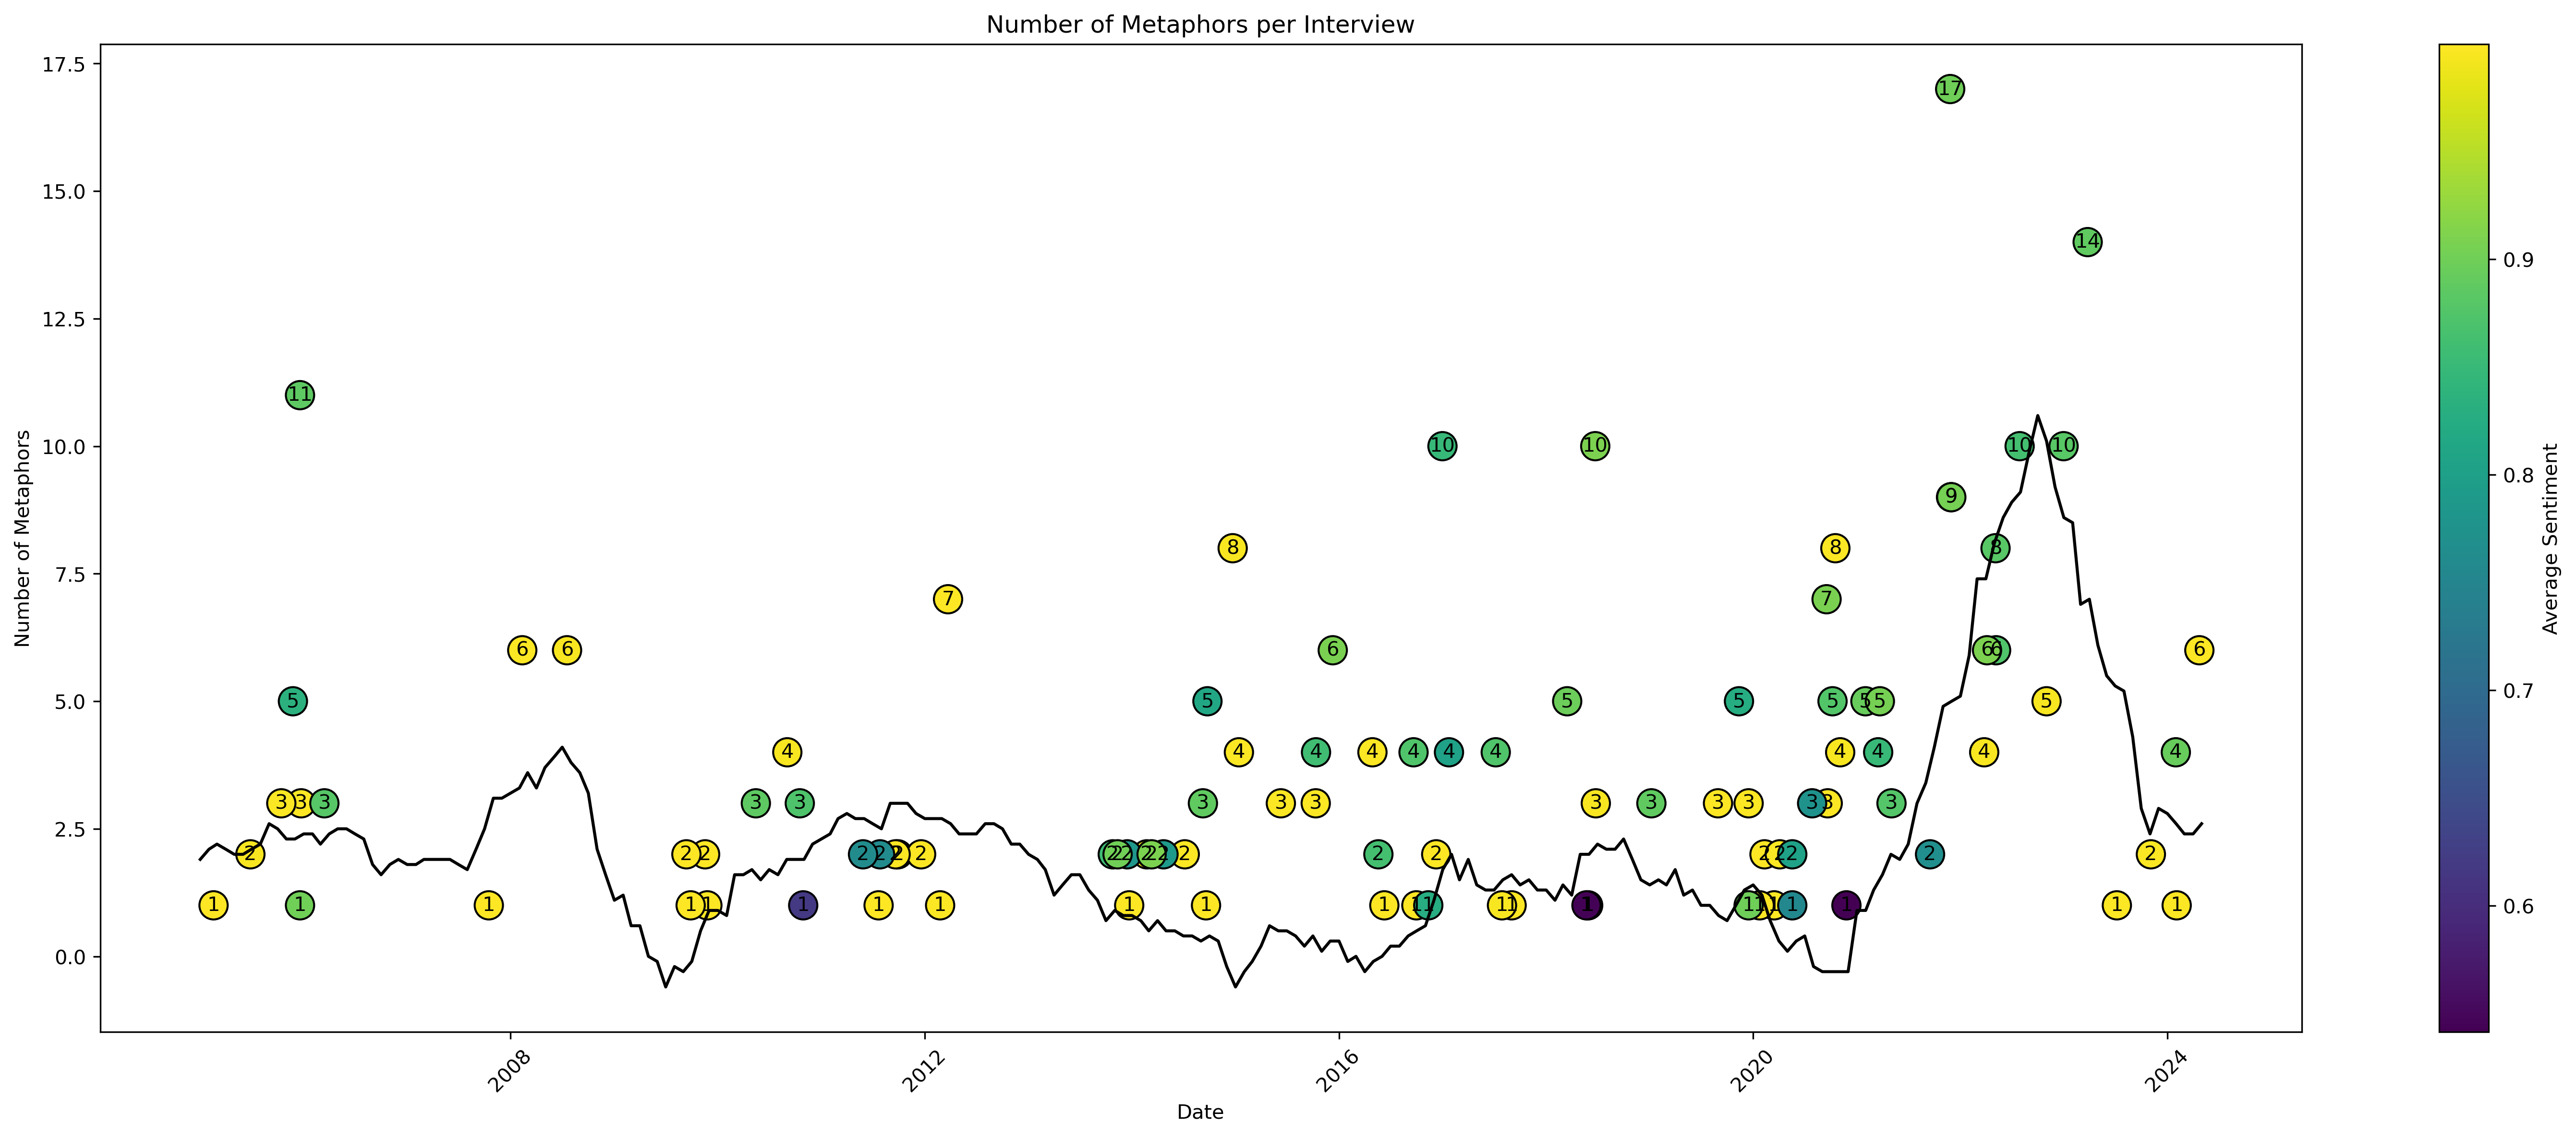

In [61]:
# Filter the top 10 and bottom 10 average sentiments
top_10 = df.nlargest(50, 'Average_Sentiment')
bottom_10 = df.nsmallest(50, 'Average_Sentiment')
filtered_df = pd.concat([top_10, bottom_10])

# Normalize the color based on the filtered data
norm = mcolors.Normalize(vmin=filtered_df['Average_Sentiment'].min(), vmax=filtered_df['Average_Sentiment'].max())
cmap = plt.cm.get_cmap('viridis')

# Create scatter plot
plt.figure(figsize=(20, 8), dpi=300)
sc = plt.scatter(filtered_df['Date'], filtered_df['GPT_Length'], c=filtered_df['Average_Sentiment'], cmap=cmap, norm=norm, s=200, edgecolors='k')

# Add text length colorbar
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Average Sentiment')

# Add metaphor count labels inside the points
for i, row in filtered_df.iterrows():
    plt.text(row['Date'], row['GPT_Length'], str(row['GPT_Length']), ha='center', va='center', color='white' if row['Average_Sentiment'] < 0.5 else 'black')

# Plot line for OBS_VALUE from df2 (make sure df2 is already loaded and has the required columns)
plt.plot(df2['TIME_PERIOD'], df2['OBS_VALUE'], color='black', label='OBS_VALUE')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Number of Metaphors')
plt.title('Number of Metaphors per Interview')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()
